In [1]:
%load_ext autoreload
import ddls

Initialise what type(s) of nodes (servers) you want in your cluster and what type(s) of worker(s) you want to populate them with.

In [2]:
%autoreload
from ddls.devices.processors.gpus.A100 import A100

node_config = {'type_1':
                  {
                      'num_nodes': 16,
                      'workers_config': 
                          [
                              {
                               'num_workers': 4,
                               'worker': A100
                              }
                          ]
                  }
              }

print(node_config)

{'type_1': {'num_nodes': 16, 'workers_config': [{'num_workers': 4, 'worker': <class 'ddls.devices.processors.gpus.A100.A100'>}]}}


Initialise the topology to be populated by your nodes.

In [3]:
topology_config = {'type':
                      'torus',
                   'kwargs':
                      {
                          'x_dims': 4,
                          'y_dims': 4
                      }
                  }

Initialise the cluster environment using your node and topology configuration.

Cluster <class 'ddls.environments.cluster.cluster_environment.ClusterEnvironment'> | Topology: <class 'ddls.topologies.torus.Torus'> with 16 nodes and 32 | Topology config: {'type': 'torus', 'kwargs': {'x_dims': 4, 'y_dims': 4}} | Node config: {'type_1': {'num_nodes': 16, 'workers_config': [{'num_workers': 4, 'worker': <class 'ddls.devices.processors.gpus.A100.A100'>}]}}


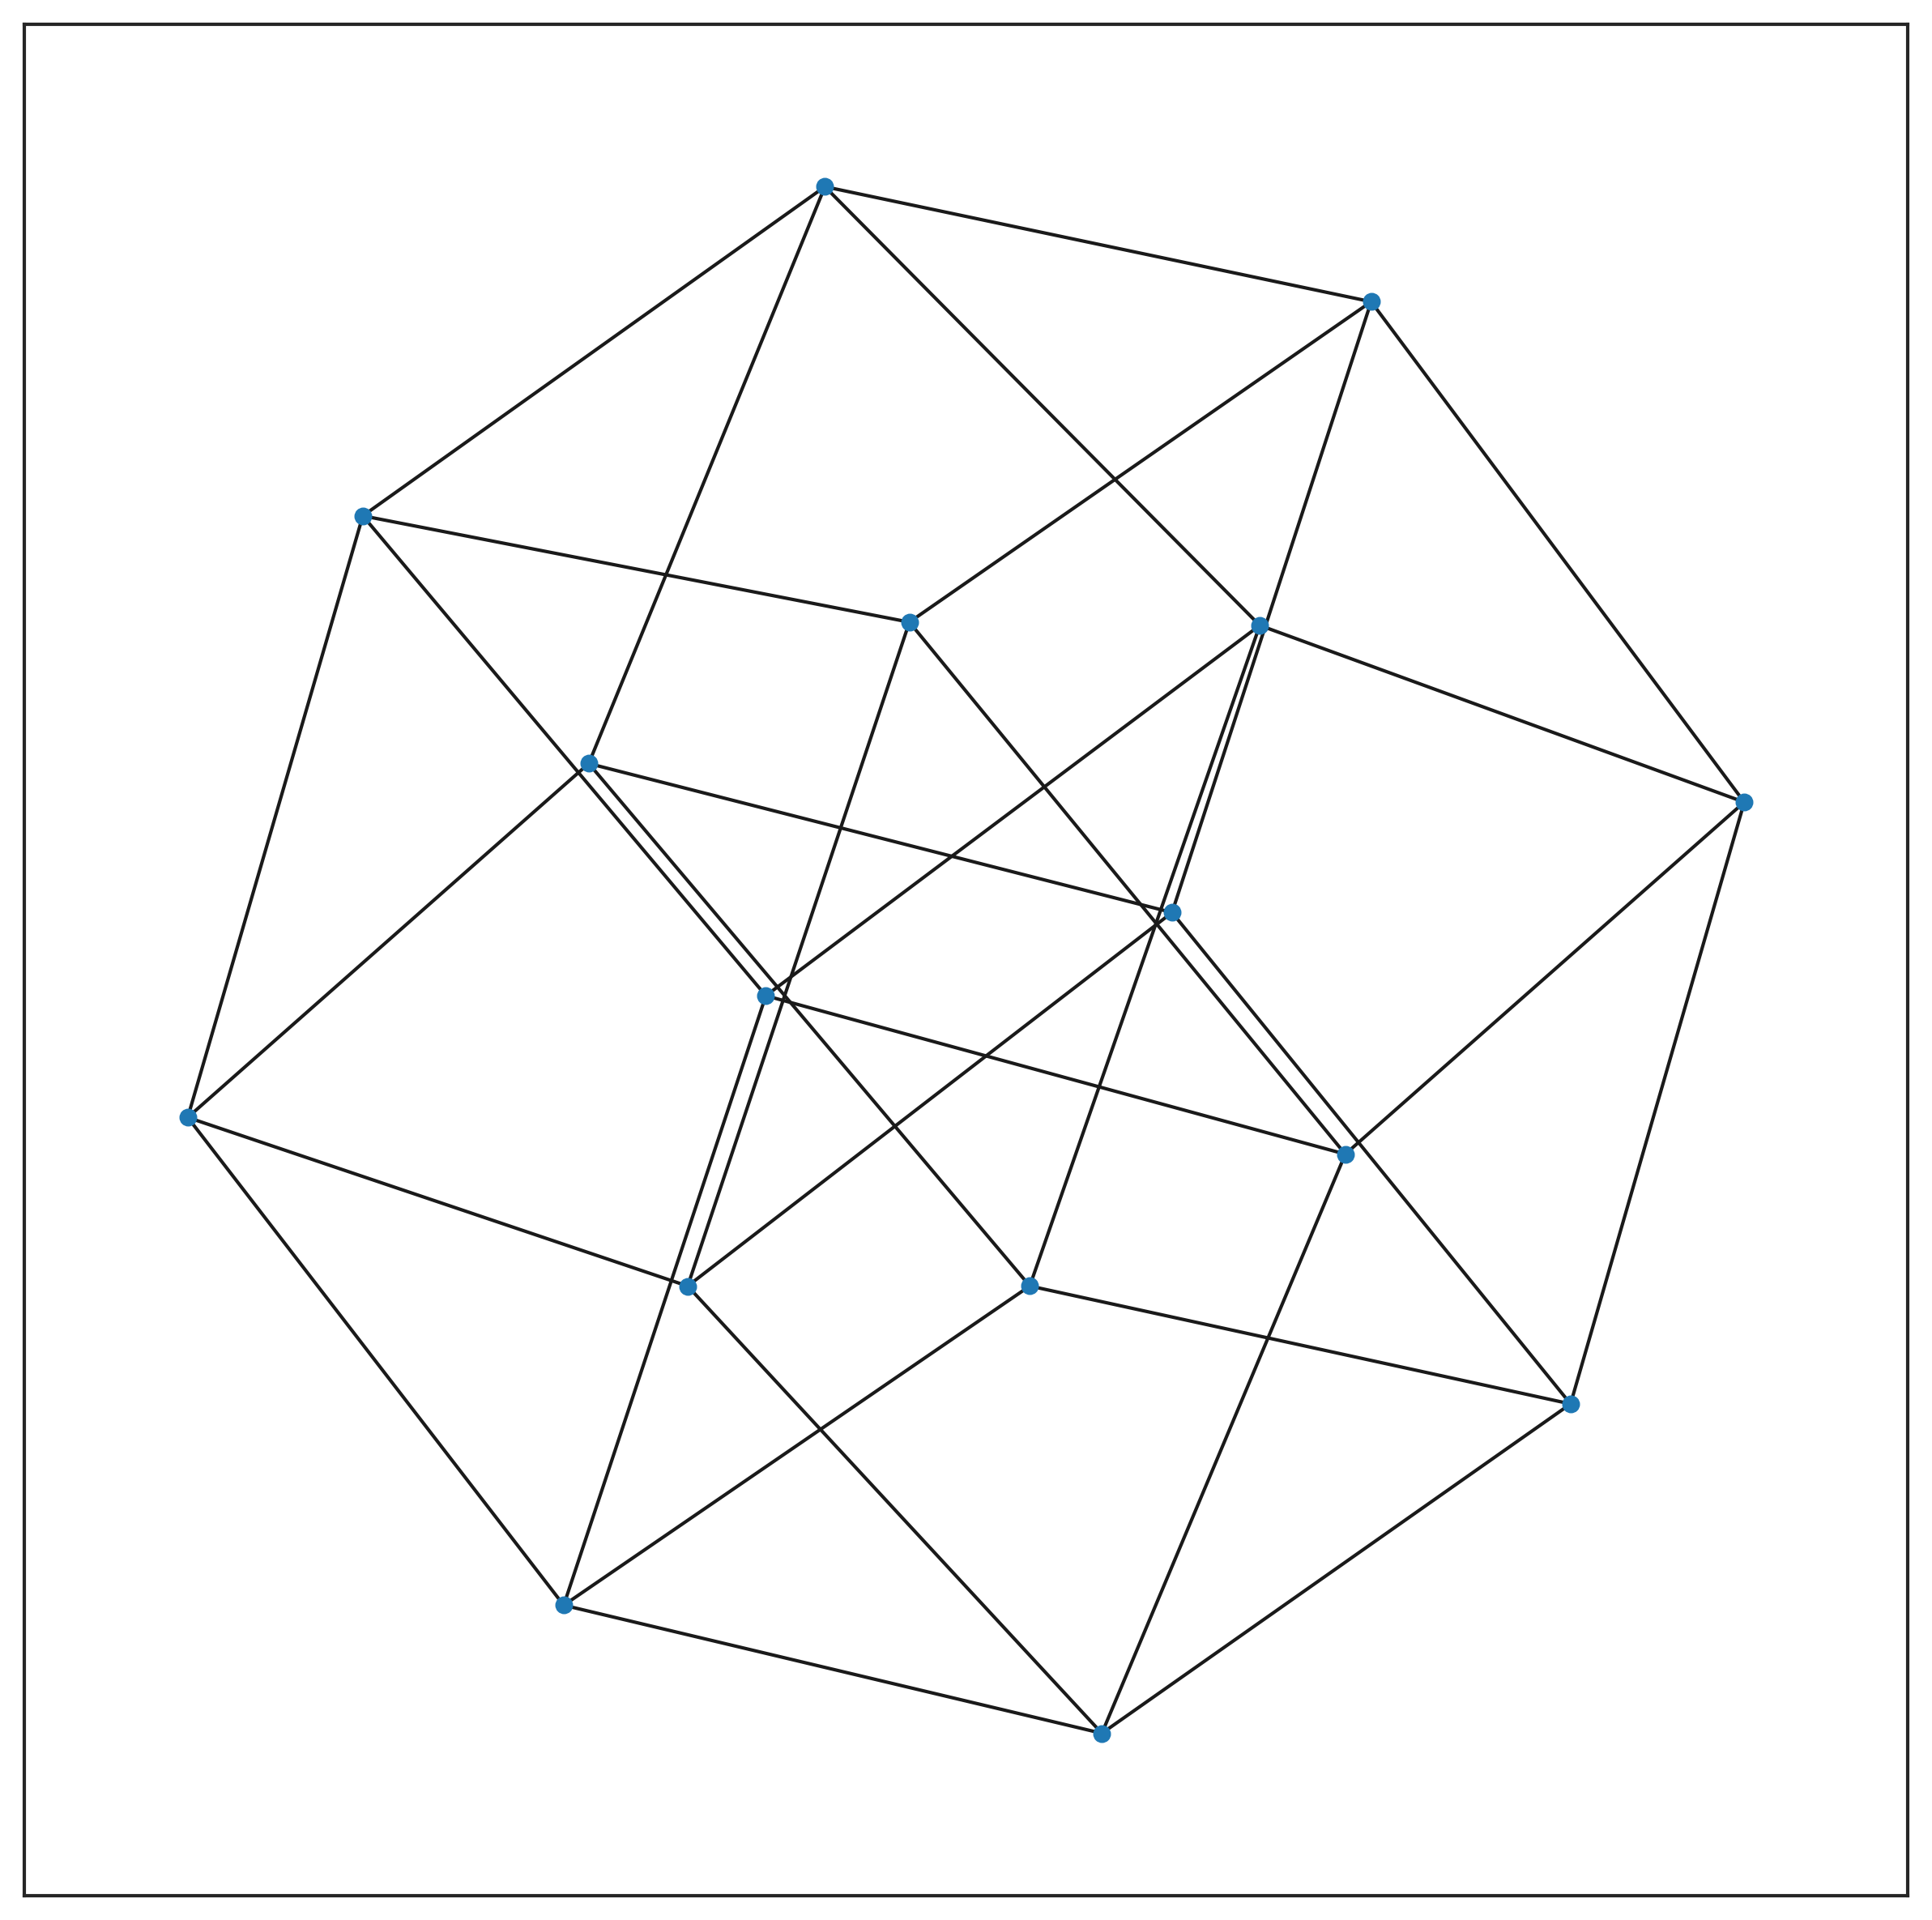

Node 1-1-1: {'workers': {140703168151264: <ddls.devices.processors.gpus.A100.A100 object at 0x7ff8025b3ee0>, 140703168149824: <ddls.devices.processors.gpus.A100.A100 object at 0x7ff8025b3940>, 140703168149008: <ddls.devices.processors.gpus.A100.A100 object at 0x7ff8025b3610>, 140703168147808: <ddls.devices.processors.gpus.A100.A100 object at 0x7ff8025b3160>}}
Node 2-1-1: {'workers': {140703168150784: <ddls.devices.processors.gpus.A100.A100 object at 0x7ff8025b3d00>, 140703168150832: <ddls.devices.processors.gpus.A100.A100 object at 0x7ff8025b3d30>, 140703168149872: <ddls.devices.processors.gpus.A100.A100 object at 0x7ff8025b3970>, 140703168148768: <ddls.devices.processors.gpus.A100.A100 object at 0x7ff8025b3520>}}
Node 3-1-1: {'workers': {140703168151072: <ddls.devices.processors.gpus.A100.A100 object at 0x7ff8025b3e20>, 140703168151168: <ddls.devices.processors.gpus.A100.A100 object at 0x7ff8025b3e80>, 140703168151024: <ddls.devices.processors.gpus.A100.A100 object at 0x7ff8025b3df0>,

In [15]:
%autoreload
from ddls.environments.cluster.cluster_environment import ClusterEnvironment

env = ClusterEnvironment(topology_config=topology_config,
                          node_config=node_config,
                          path_to_save='/scratch/datasets/ddls/sims',
                          save_freq=100,
                          use_sqlite_database=True)
print(env)
env.topology.render()

for node in env.topology.graph:
    print(f'Node {node}: {env.topology.graph.nodes[node]}')

Load the `ddls` computation graph(s) you want to run on the cluster.

In [16]:
%autoreload
from ddls.utils import ddls_graph_from_pbtxt_file
from ddls.plotting.plotting import plot_computation_graph

import glob


# get file paths
path_to_files = '/scratch/datasets/ddls/jobs/tensorflow_synthetic_graphs/valid'
file_paths = glob.glob(path_to_files + '/*')
    
# create ddls graph
num_graphs = 2
ddls_computation_graphs = [ddls_graph_from_pbtxt_file(file_path, processor_type_profiled='A100', verbose=False) for file_path in file_paths[:num_graphs]]

# visualise
visualise = False
if visualise:
    for graph in ddls_computation_graphs:
        fig = plot_computation_graph(graph, scaling_factor=3, title='ddls_graph', show_fig=True, verbose=True)

Initialise `ddls` job(s) from the computation graph(s)

In [17]:
%autoreload
from ddls.demands.jobs.job import Job

jobs = [Job(computation_graph=graph, num_training_steps=2) for graph in ddls_computation_graphs]

for job in jobs:
    print(job)

Job ID: 140703169953024 | # nodes: 96 | # edges: 410 | # training steps: 2 | Total op mem cost: 0 | Total dep size: 13897
Job ID: 140703168149536 | # nodes: 68 | # edges: 128 | # training steps: 2 | Total op mem cost: 0 | Total dep size: 4059


Initialise an operation placement agent.

In [18]:
%autoreload
from ddls.managers.placers.random_job_placer import RandomJobPlacer
from ddls.managers.schedulers.srpt_job_scheduler import SRPTJobScheduler

control_plane = {
    'job_placer': RandomJobPlacer(),
    'job_scheduler': SRPTJobScheduler()
}

Reset cluster environment and run `Cluster`

In [19]:
%autoreload
from ddls.distributions.uniform import Uniform
from ddls.utils import seed_stochastic_modules_globally

import time
import pprint


# seeds = [0, 1, 2]
seeds = [0]
for seed in seeds:
    print(f'\n\n\n~~~~~~~~~~~~~~~~~~~~~~~ Seed {seed} ~~~~~~~~~~~~~~~~~~~~~~~')
    seed_stochastic_modules_globally(seed)
    obs, action_set, reward, done, info = env.reset(jobs=jobs,
                                                    job_sampling_mode='remove',
                                                    job_interarrival_time_dist=Uniform(min_val=1, max_val=1000),
                                                    max_simulation_run_time=float('inf'),
                                                    job_queue_capacity=10,
                                                    seed=seed,
                                                    verbose=True)
    
    start_time = time.time()
    while not done:
        # make decisions
        actions = {}
        actions['job_placement'] = control_plane['job_placer'].get_placement(cluster=env)
        actions['job_schedule'] = control_plane['job_scheduler'].get_schedule(new_placements=actions['job_placement'], cluster=env)

        # pass actions to cluster environment and step the cluster
        obs, action_set, reward, done, info = env.step(actions, verbose=True)

#         print(f'Step {env.step_counter} | Jobs arrived: {env.num_jobs_arrived} | completed: {len(env.jobs_completed)} | blocked: {len(env.jobs_blocked)} | running: {len(env.jobs_running)} | queued: {len(env.job_queue)}')

    print(f'\nCompleted simulation in {time.time() - start_time:.3f} s')




~~~~~~~~~~~~~~~~~~~~~~~ Seed 0 ~~~~~~~~~~~~~~~~~~~~~~~
Initialised folder /scratch/datasets/ddls/sims/cluster/cluster_33/reset_1
Reset cluster environment.
Job interarrival time dist: Distribution type: <class 'ddls.distributions.uniform.Uniform'> | min_val: 1 | max_val: 1000 | interval: 1 | decimals: 10
Job sampler: Original pool length: 2 | Current pool length: 1 | Sampling mode: remove
Max sim run time: inf

--------------------------------------------------------------------------------
Step: 0
New job(s) to place on cluster. Placing...
Job ID: 140703169953024 | Job idx: 0 | Time arrived: 0
Op ID 0 of job index 0 placed on node ID 1-4-1 worker ID 140703168132624
Op ID 1 of job index 0 placed on node ID 2-4-1 worker ID 140703170080976
Op ID 2 of job index 0 placed on node ID 2-1-1 worker ID 140703168150832
Op ID 3 of job index 0 placed on node ID 1-3-1 worker ID 140703167800368
Op ID 4 of job index 0 placed on node ID 4-4-1 worker ID 140703169953552
Op ID 5 of job index 0 placed 

Ticking op 52 with remaining run time 93 of job index 1 on node 2-2-1 worker 140703167537360 by amount 7
Ticking op 33 with remaining run time 280 of job index 1 on node 2-2-1 worker 140703167538992 by amount 7
Ticking op 26 with remaining run time 7 of job index 1 on node 1-3-1 worker 140703167800368 by amount 7
Op 26 of job index 1 completed
Ticking op 37 with remaining run time 53 of job index 0 on node 3-3-1 worker 140703167800416 by amount 7
Ticking op 57 with remaining run time 27 of job index 1 on node 4-3-1 worker 140703168133776 by amount 7
Ticking op 51 with remaining run time 70 of job index 1 on node 3-4-1 worker 140703169949856 by amount 7
job_idx_to_completed_op_ids: defaultdict(<class 'list'>, {1: [26]})
Finished cluster tick. Stopwatch time at end of tick: 888
--------------------------------------------------------------------------------
Performing cluster tick. Stopwatch time at start of tick: 888
Ticking op 65 with remaining run time 149 of job index 1 on node 2-1-1

--------------------------------------------------------------------------------
Performing cluster tick. Stopwatch time at start of tick: 2414
Ticking op 65 with remaining run time 10 of job index 1 on node 2-1-1 worker 140703168150832 by amount 10
Op 65 of job index 1 completed
Ticking op 22 with remaining run time 109 of job index 1 on node 2-1-1 worker 140703168148768 by amount 10
Ticking op 27 with remaining run time 61 of job index 1 on node 3-1-1 worker 140703168151072 by amount 10
Ticking op 60 with remaining run time 83 of job index 1 on node 1-2-1 worker 140703167540480 by amount 10
Ticking op 43 with remaining run time 130 of job index 1 on node 2-2-1 worker 140703167538608 by amount 10
Ticking op 52 with remaining run time 23 of job index 1 on node 2-2-1 worker 140703167537360 by amount 10
Ticking op 33 with remaining run time 121 of job index 1 on node 2-2-1 worker 140703167538992 by amount 10
Ticking op 76 with remaining run time 139 of job index 0 on node 3-2-1 worker 14

Saved logs to /scratch/datasets/ddls/sims/cluster/cluster_33/reset_1/ in 0.2896 s.
No more jobs running, in queue, or left to sample -> done.

Completed simulation in 0.822 s


**TODO**: Implement logic for placing job ops of each job -> step env -> time job completion for 1 training step (can then think about $n$ training steps, network communication overhead, etc.)

- Have mounted job onto devices
- Now need to work out way of tracking ops running on each device efficiently and timing how long they take. Consider having global dict tracking operations which are running to avoid having to keep looping through all ops to check dependencies. Consider also having stopwatch object similar to Noah's where only tick it when have stacked enough sequential operations. N.B. Think should assume that, once ops have been placed on a device, they must be ran sequentially (i.e. cannot run multiple ops on one device at the same time; assume time profile is for e.g. GPU worker running just that one op with <= all its cores)

Lets load our SQLite logs and plot some data.

In [9]:
%autoreload
from collections import defaultdict
from sqlitedict import SqliteDict
import pprint
import glob
import time


base_folder = '/scratch/datasets/ddls/sims/'
base_name = 'cluster'
ids = [20]


steps_logs_dict = defaultdict(lambda : defaultdict(list))
sim_logs_dict = defaultdict(lambda : defaultdict(list))
start_time = time.time()
for i in ids:
    agent = base_name + f'_{i}'
    paths = [reset_folder for reset_folder in glob.glob(base_folder + f'/{base_name}/{agent}/*/')]
    
    for path in paths:
        with SqliteDict(path + '/steps_log.sqlite') as log:
            for key, val in log.items():
                steps_logs_dict[agent][key].extend(val)
            log.close()

        with SqliteDict(path + '/sim_log.sqlite') as log:
            for key, val in log.items():
                sim_logs_dict[agent][key].extend(val)
            log.close()
        
print(f'\nsteps_logs_dict: {steps_logs_dict}\n')
print(f'\nsim_logs_dict: {sim_logs_dict}\n')
print(f'\nAll data loaded in {time.time() - start_time:.3f} s.')


steps_logs_dict: defaultdict(<function <lambda> at 0x7ff8301a8280>, {'cluster_20': defaultdict(<class 'list'>, {'step_counter': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 

## Step-level metrics

E.g. How many jobs, if any, were completed at each step?

In [10]:
import copy

def augment_steps_logs_dict(steps_logs_dict):
    '''Calculates additional metrics for steps logs dict.'''
    _steps_logs_dict = copy.deepcopy(steps_logs_dict)
    for agent in steps_logs_dict.keys():
        _steps_logs_dict[agent]['step_time'] = [steps_logs_dict[agent]['step_end_time'][i] - steps_logs_dict[agent]['step_start_time'][i] for i in range(len(steps_logs_dict[agent]['step_start_time']))]
    return _steps_logs_dict
steps_logs_dict = augment_steps_logs_dict(steps_logs_dict)

Metrics to plot: ['step_start_time', 'mean_num_active_workers', 'num_jobs_completed', 'num_jobs_running', 'num_jobs_arrived', 'num_jobs_blocked', 'step_end_time', 'job_queue_length', 'step_time']
Metrics to skip: {'step_counter'}

Plotting metric step_start_time


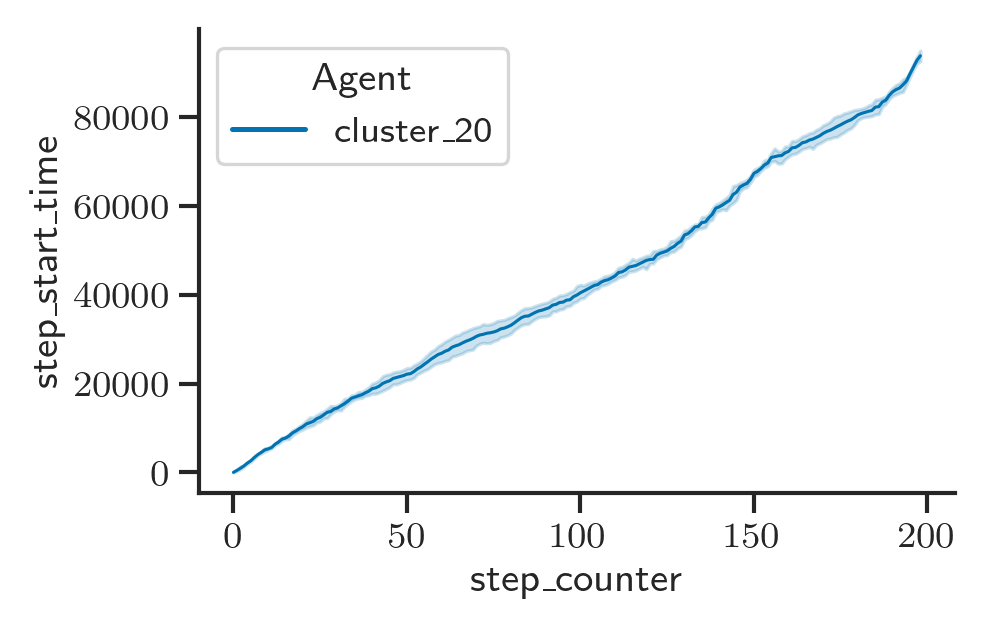

Plotting metric mean_num_active_workers


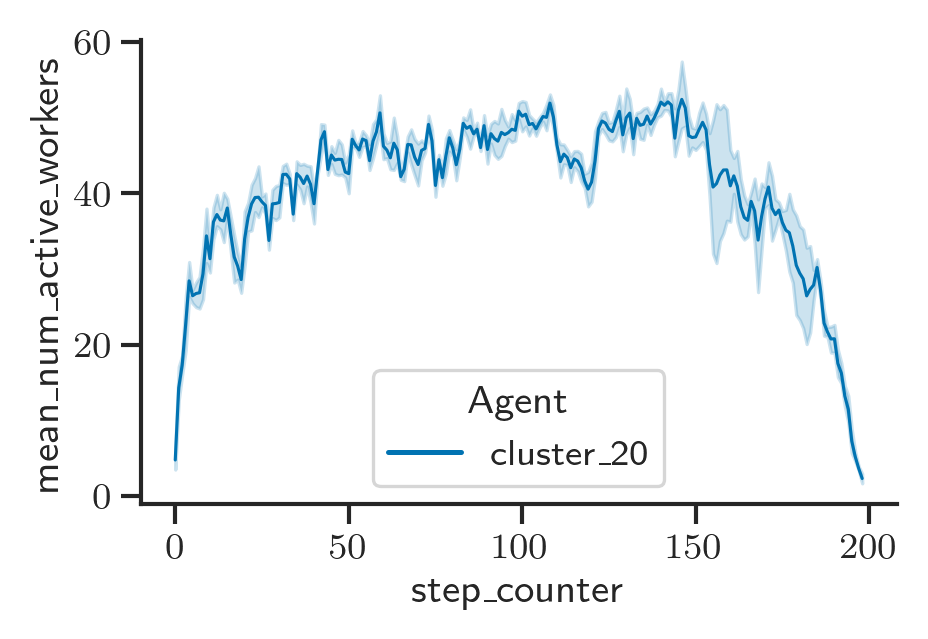

Plotting metric num_jobs_completed


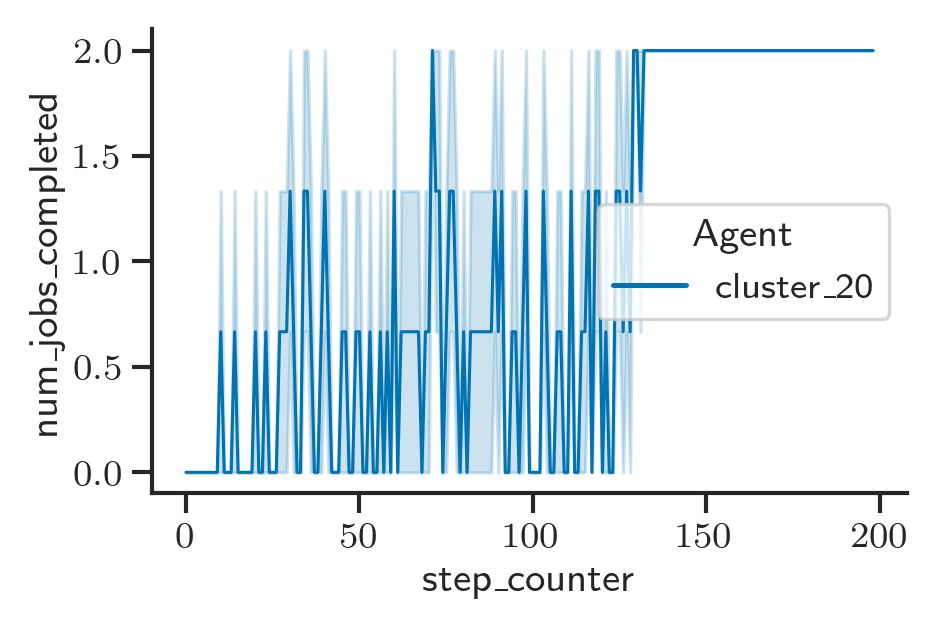

Plotting metric num_jobs_running


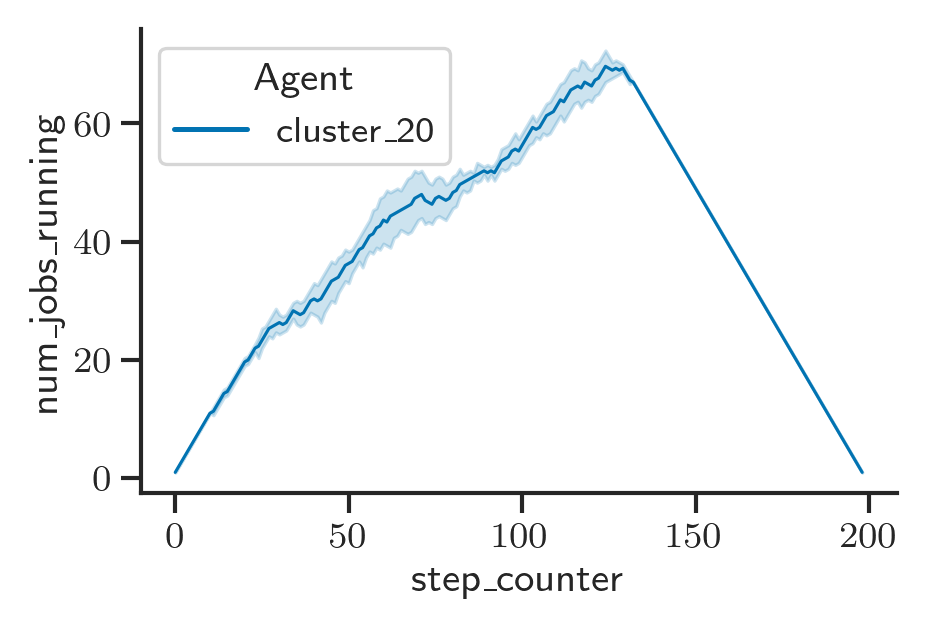

Plotting metric num_jobs_arrived


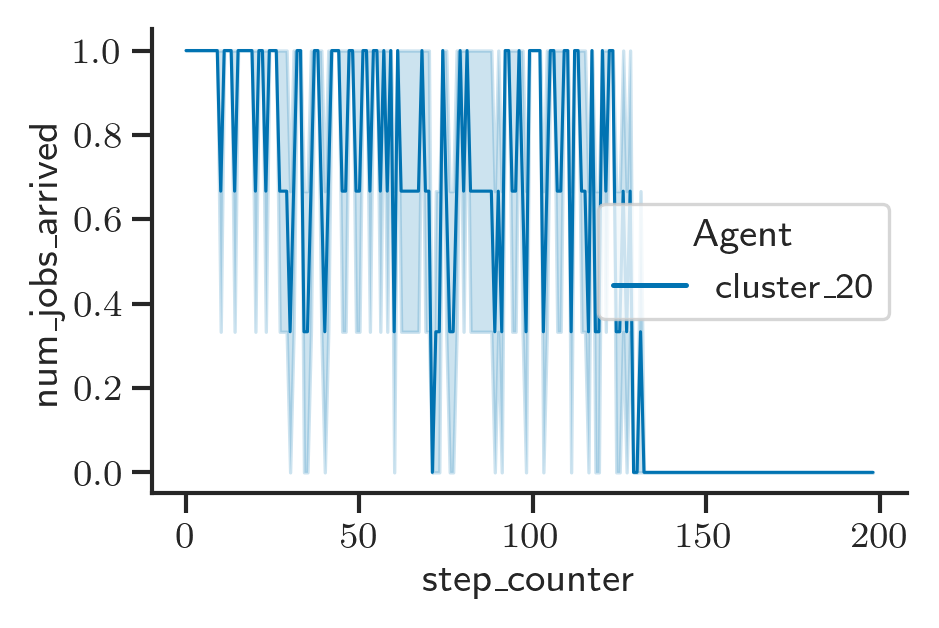

Plotting metric num_jobs_blocked


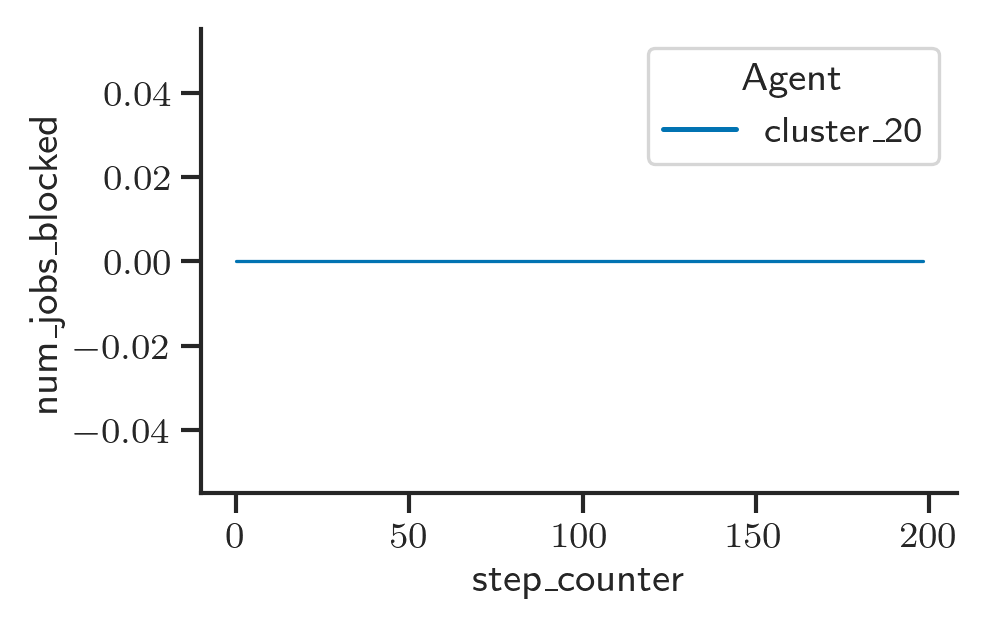

Plotting metric step_end_time


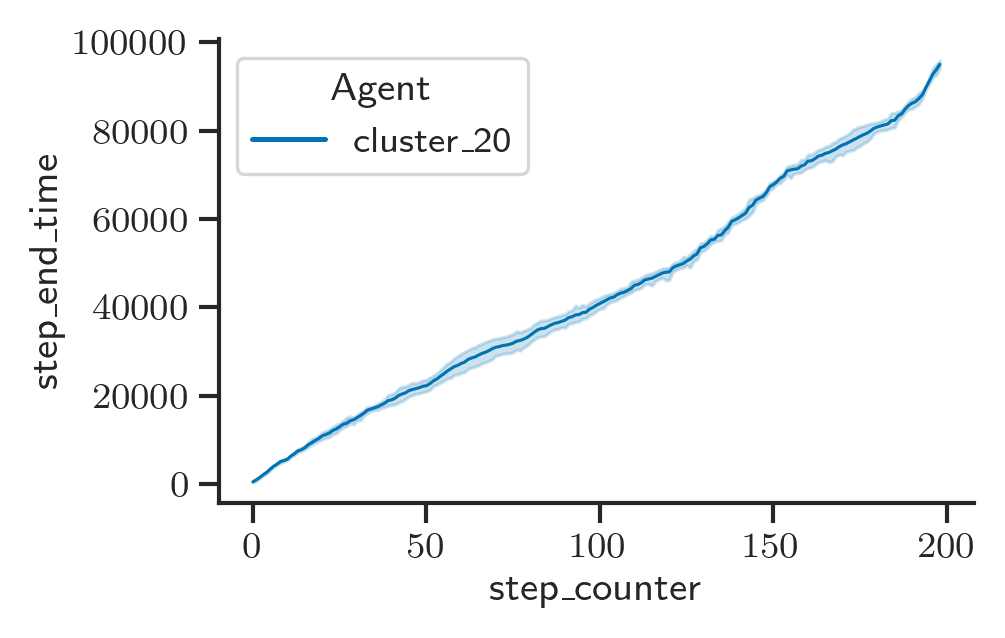

Plotting metric job_queue_length


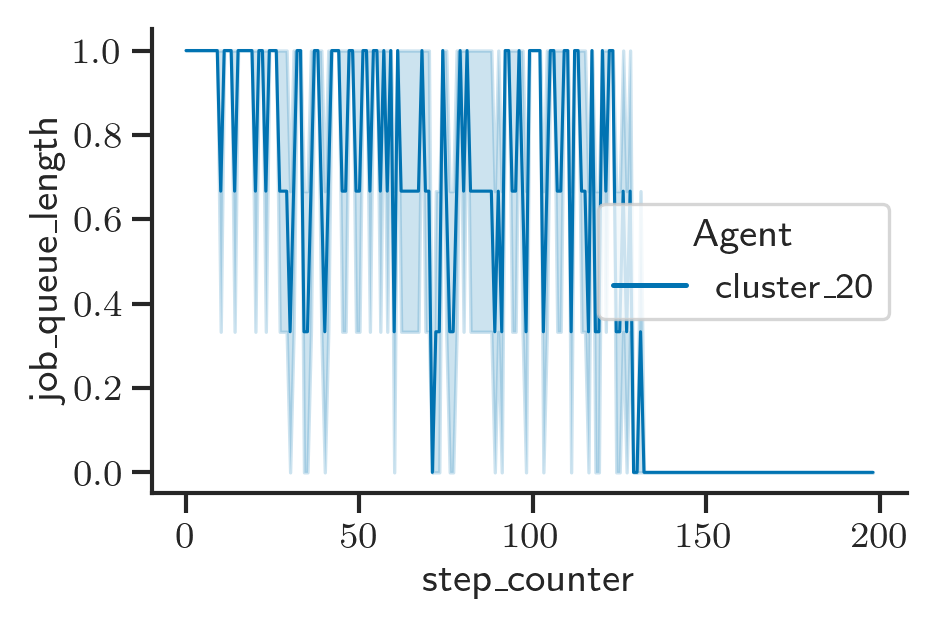

Plotting metric step_time


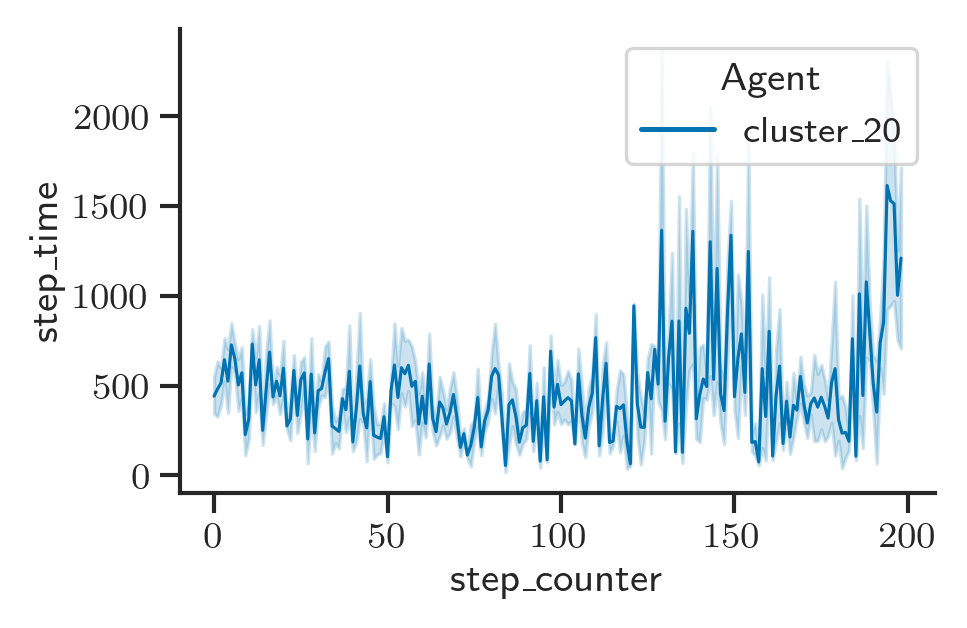

In [11]:
%autoreload
from ddls.plotting.plotting import plot_line

import pandas as pd
from collections import defaultdict


# plot config
x = 'step_counter'
scaling_factor = 1
metrics_to_skip = {'step_counter'}

# make plots
metrics = steps_logs_dict[agent].keys()
metrics_to_plot = [metric for metric in metrics if metric not in metrics_to_skip]
print(f'Metrics to plot: {metrics_to_plot}\nMetrics to skip: {metrics_to_skip}\n')
for metric in metrics_to_plot:
    print(f'Plotting metric {metric}')
    plot_dict = {}
    for _agent in steps_logs_dict.keys():
        plot_dict['Agent'] = [_agent for _ in range(len(steps_logs_dict[_agent][metric]))]
        plot_dict[x] = steps_logs_dict[_agent][x]
        plot_dict[metric] = steps_logs_dict[agent][metric]
    fig = plot_line(pd.DataFrame(plot_dict), 
                    x=x, 
                    y=metric, 
                    hue='Agent', 
                    xlabel=x, 
                    ylabel=metric, 
                    err_style='band', # 'band' 'bars'
                    ci=68, # 95 68
                    scaling_factor=scaling_factor,
                    show_fig=True)

## Sim-level metrics

E.g. Mean job completion time?

In [12]:
# import copy
# import numpy as np

# def augment_sim_logs_dict(sim_logs_dict):
#     '''Calculates additional metrics for steps logs dict.'''
#     _sim_logs_dict = copy.deepcopy(sim_logs_dict)
#     for agent in sim_logs_dict.keys():
#         for metric in ['job_completion_time']:
#             _sim_logs_dict[agent][f'mean_{metric}'] = np.mean(sim_logs_dict[agent][metric])
#             _sim_logs_dict[agent][f'p99_{metric}'] = np.percentile(sim_logs_dict[agent][metric], 99)
#             _sim_logs_dict[agent][f'median_{metric}'] = np.median(sim_logs_dict[agent][metric])
#             _sim_logs_dict[agent][f'std_{metric}'] = np.std(sim_logs_dict[agent][metric])
#     return _sim_logs_dict
# sim_logs_dict = augment_sim_logs_dict(sim_logs_dict)

Metrics to plot: ['job_completion_time', 'jobs_completed_num_nodes', 'jobs_completed_num_edges', 'jobs_completed_total_operation_memory_cost', 'jobs_completed_total_dependency_size']
Metrics to skip: {}

Plotting metric job_completion_time


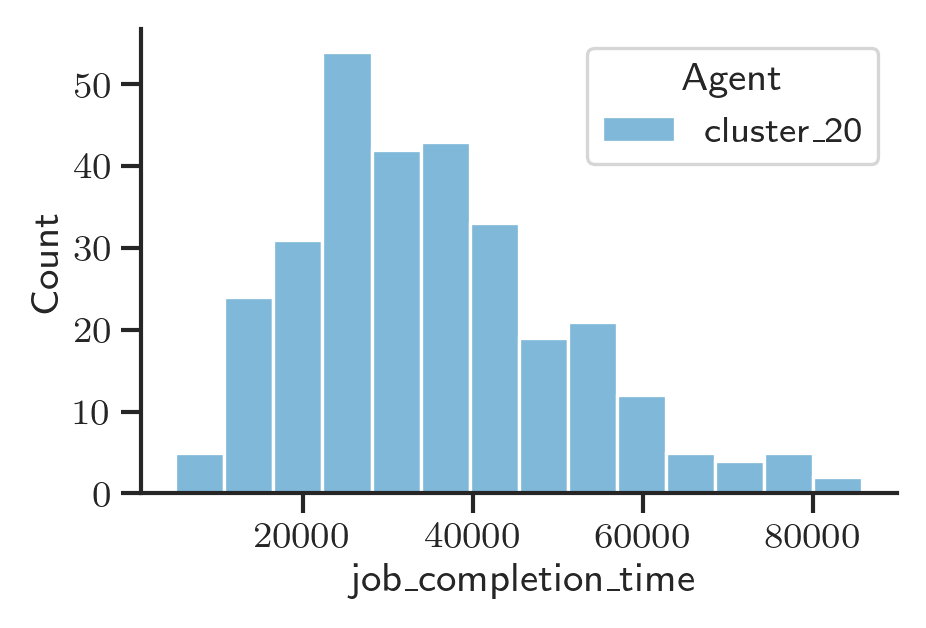

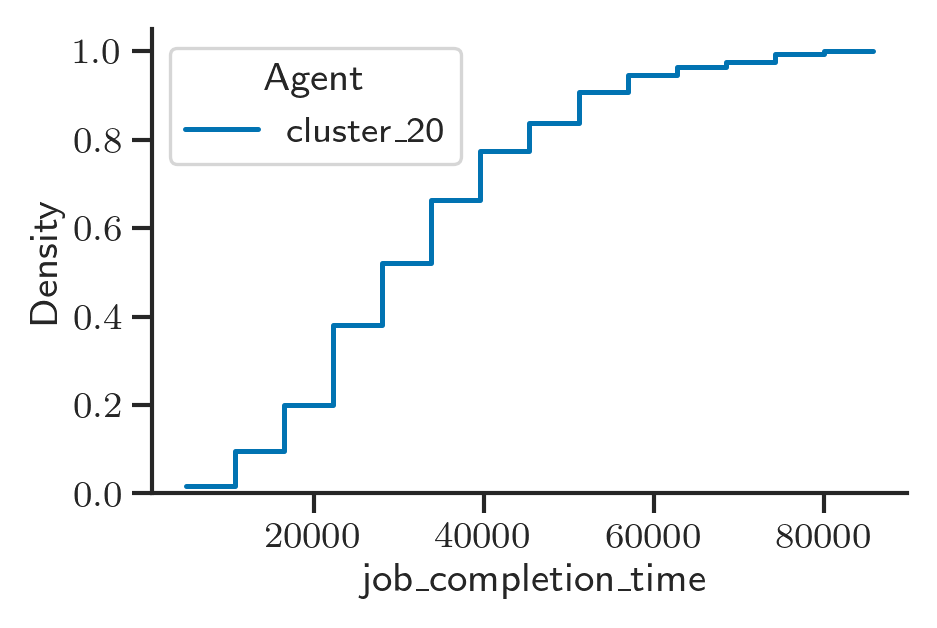

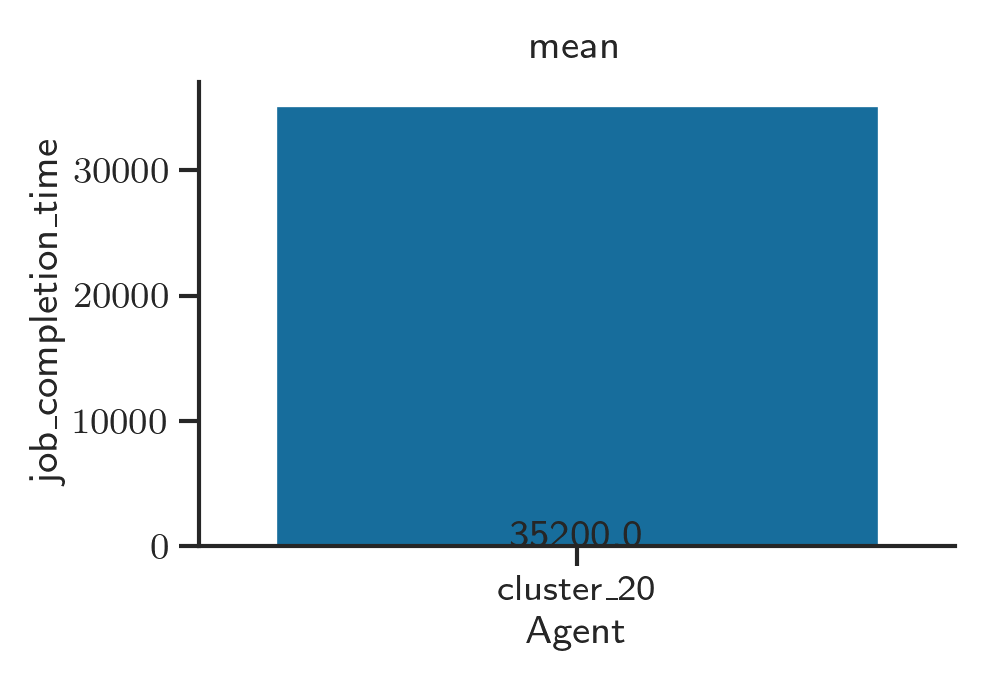

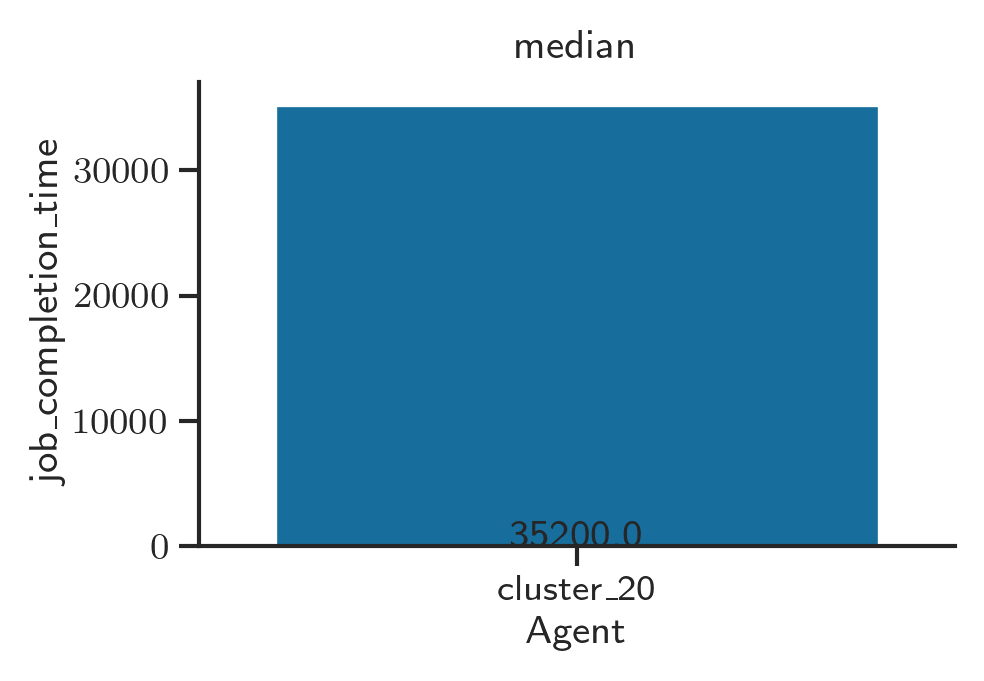

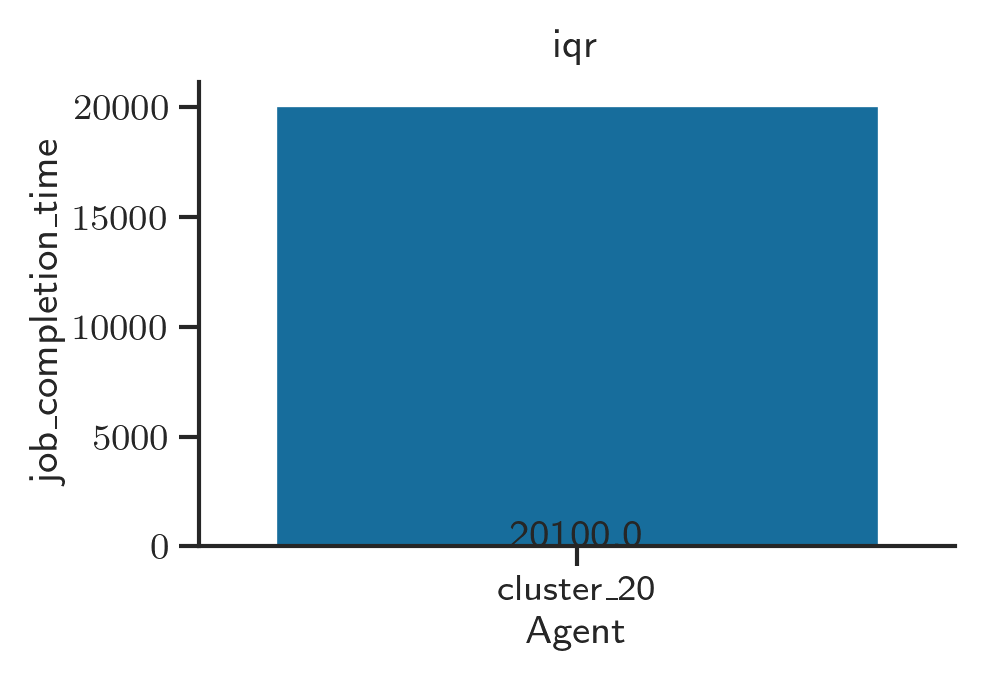

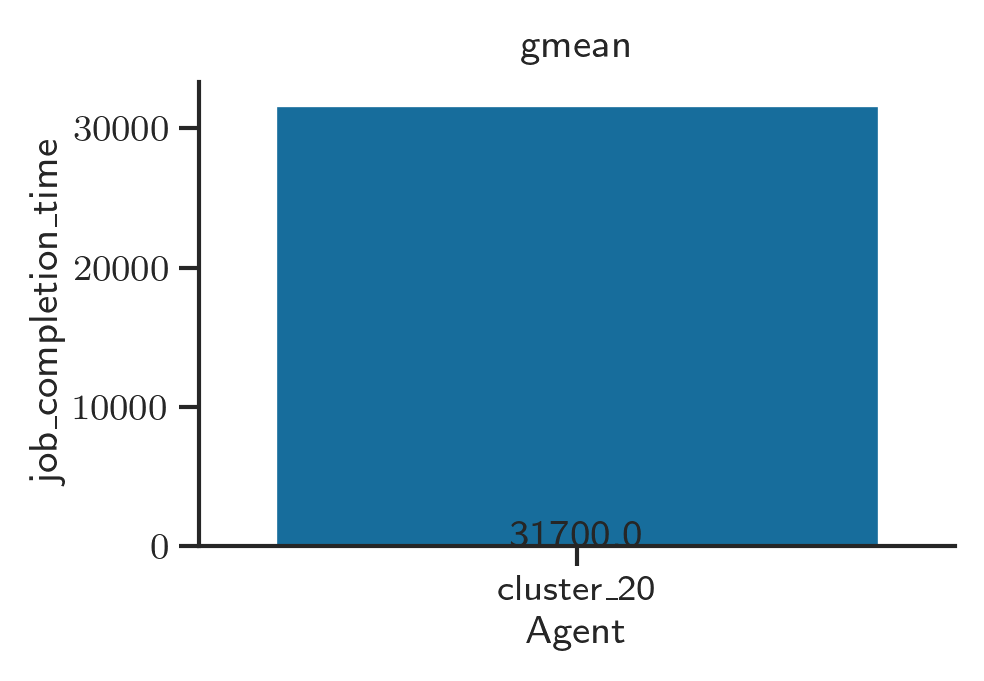

Plotting metric jobs_completed_num_nodes


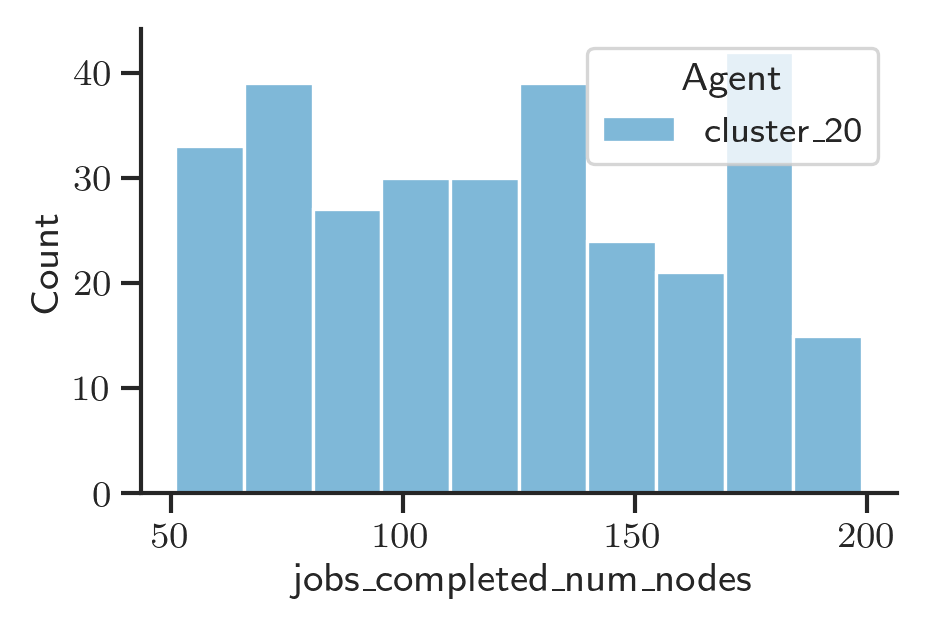

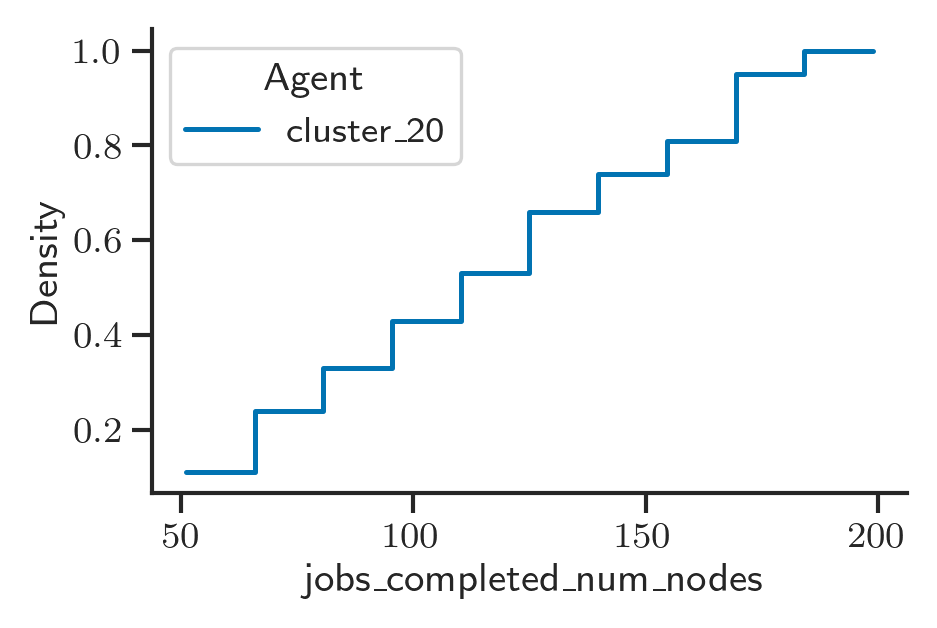

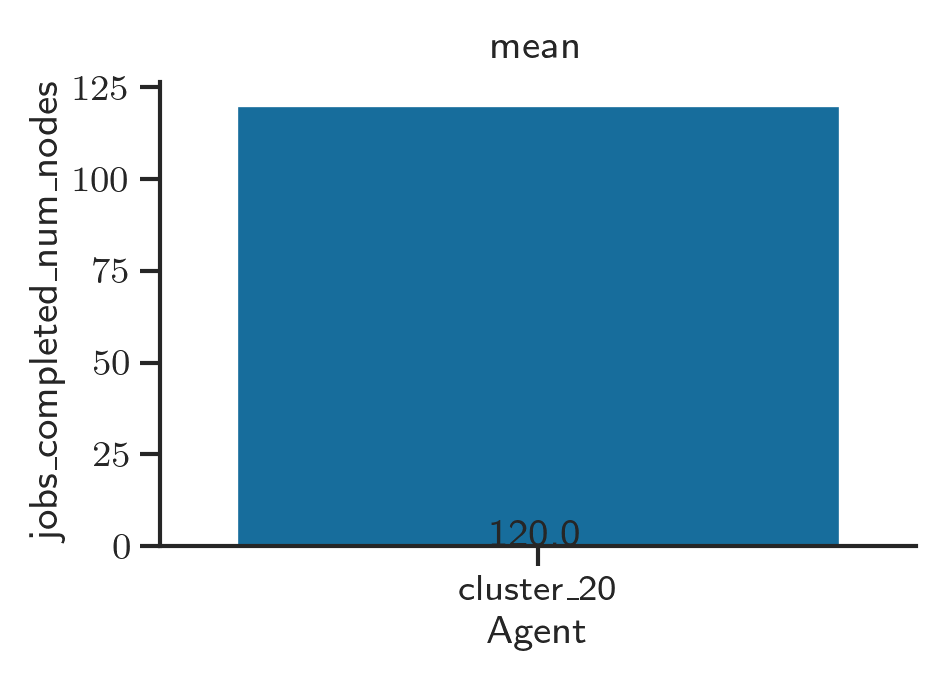

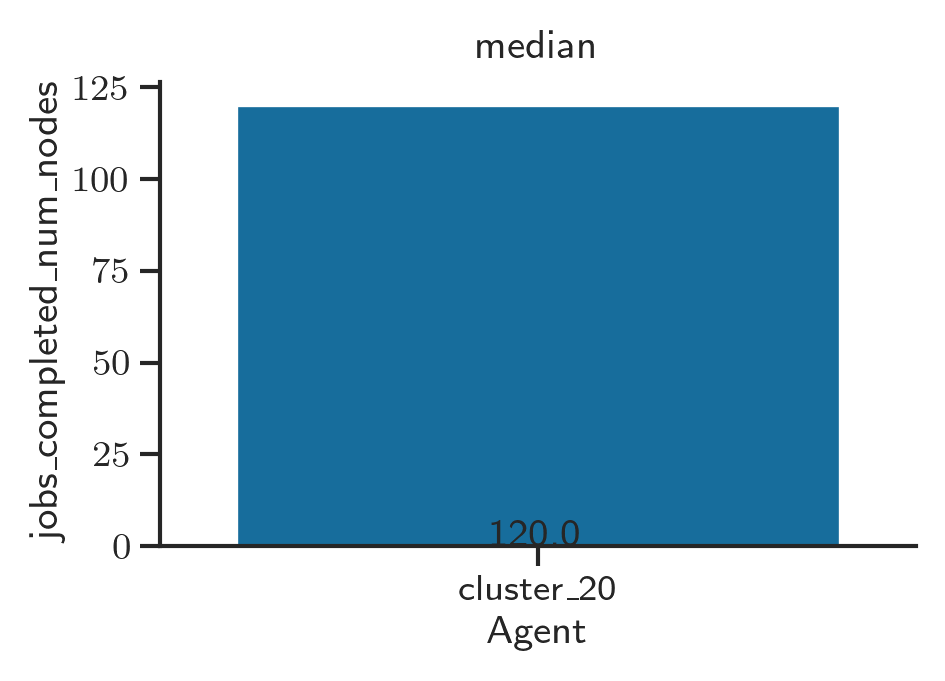

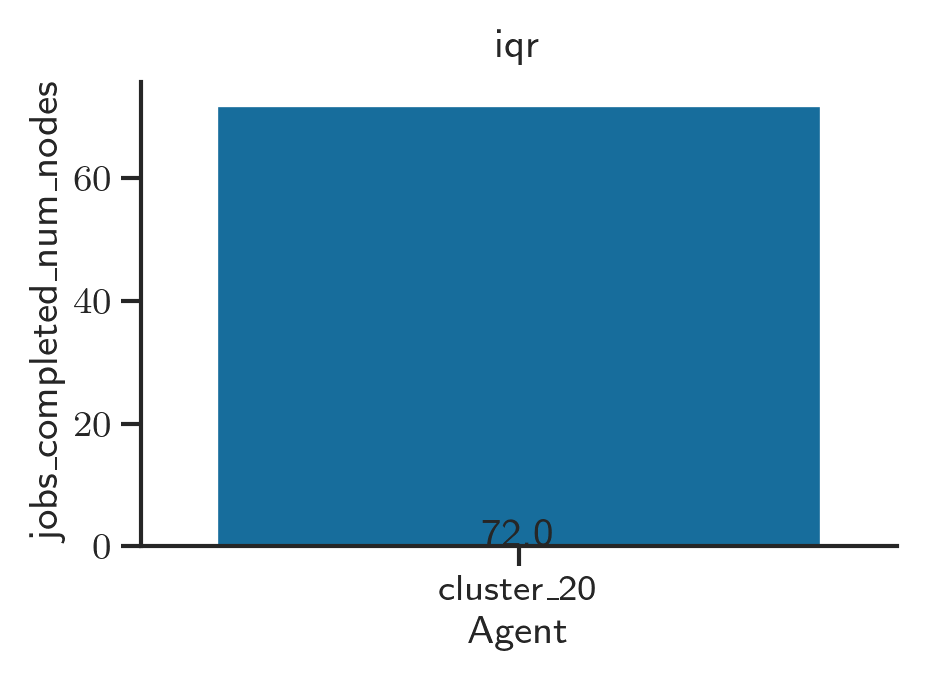

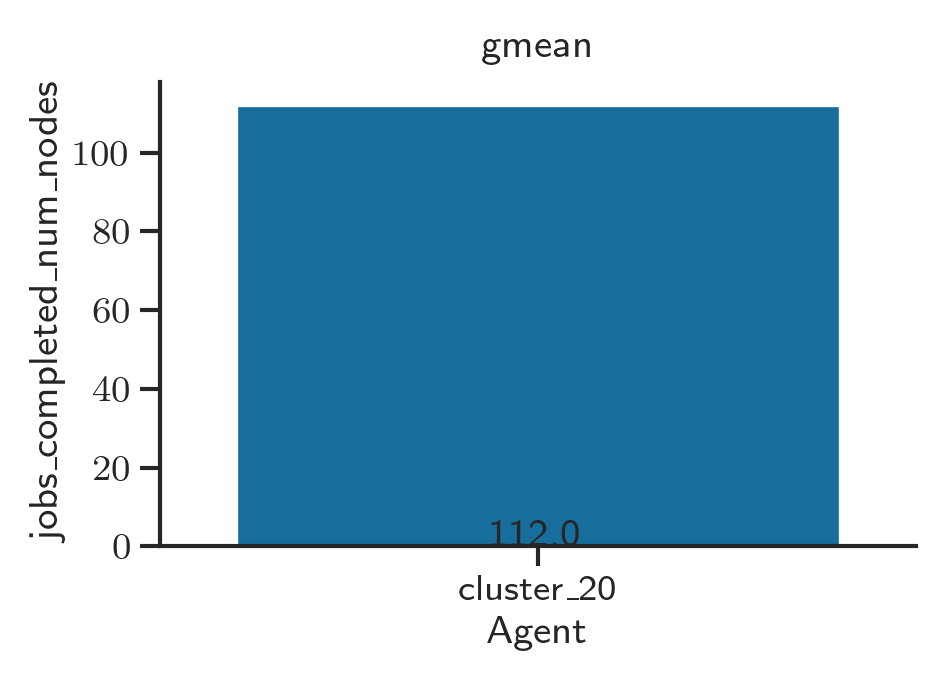

Plotting metric jobs_completed_num_edges


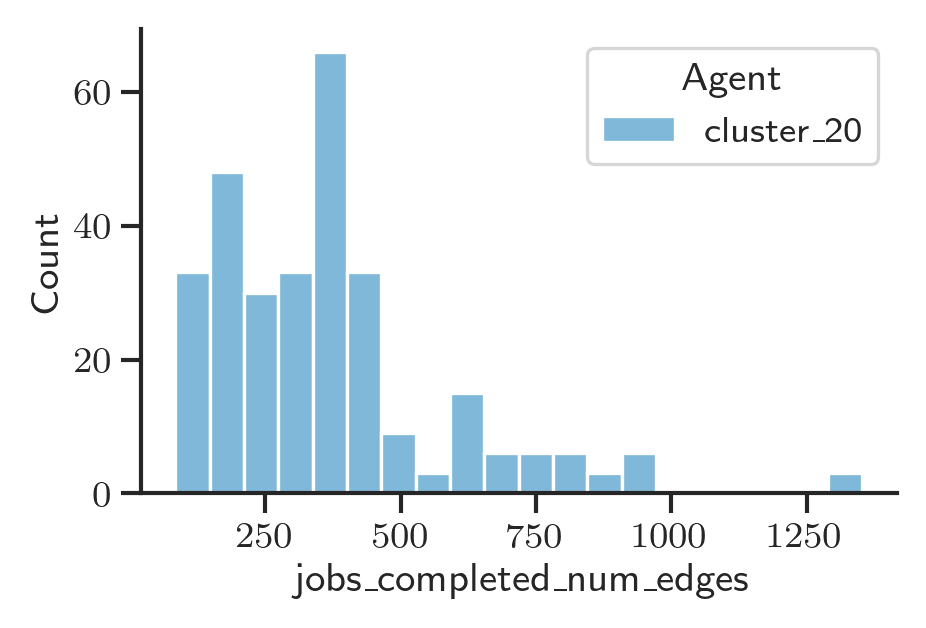

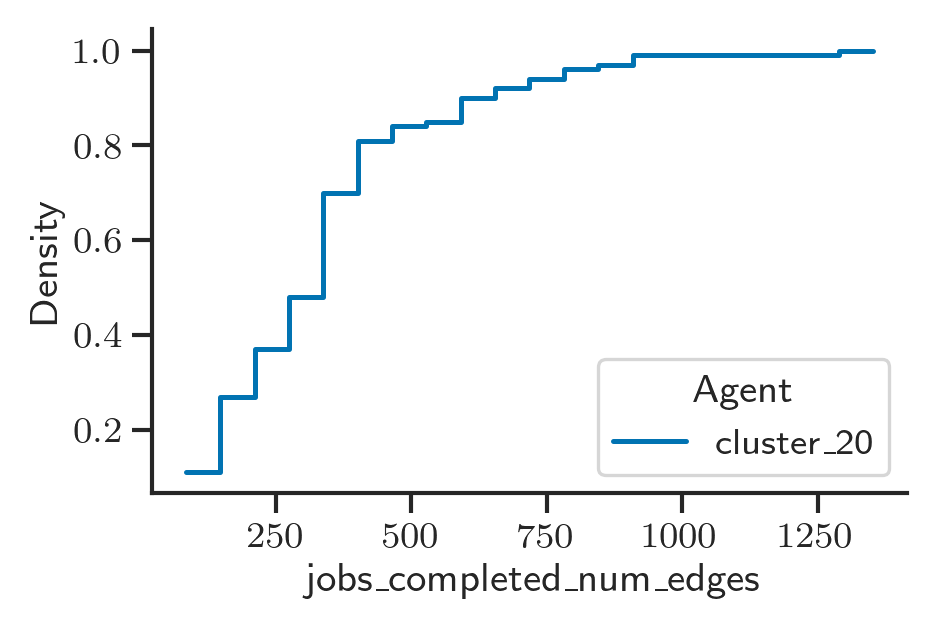

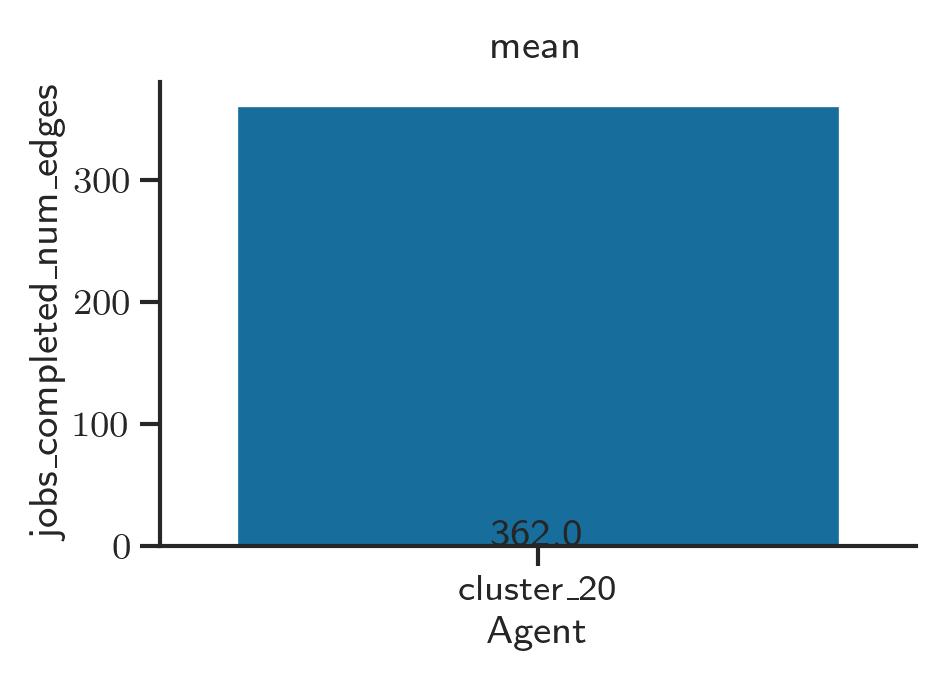

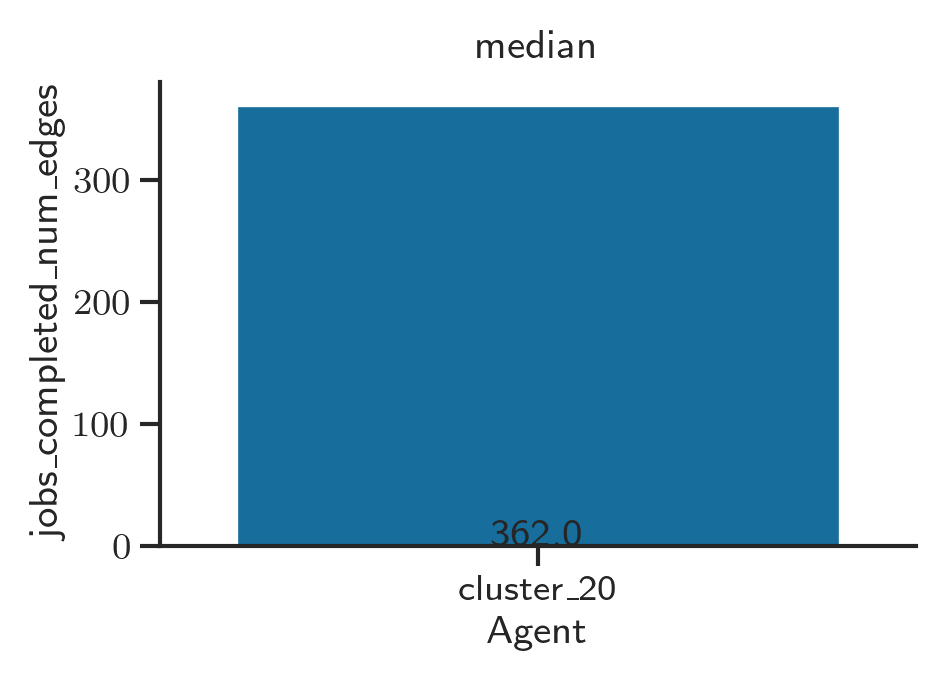

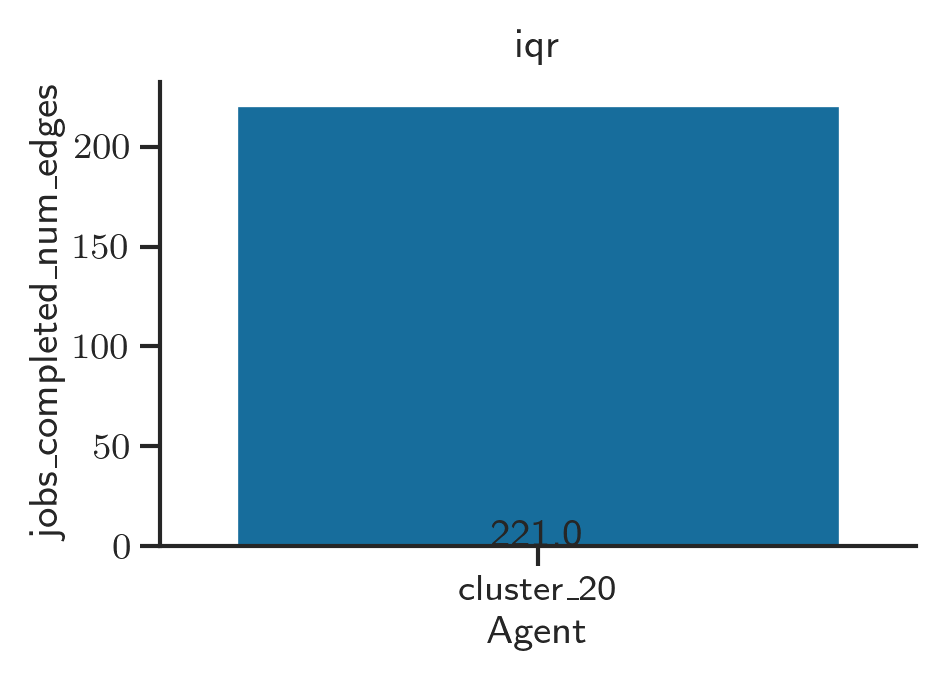

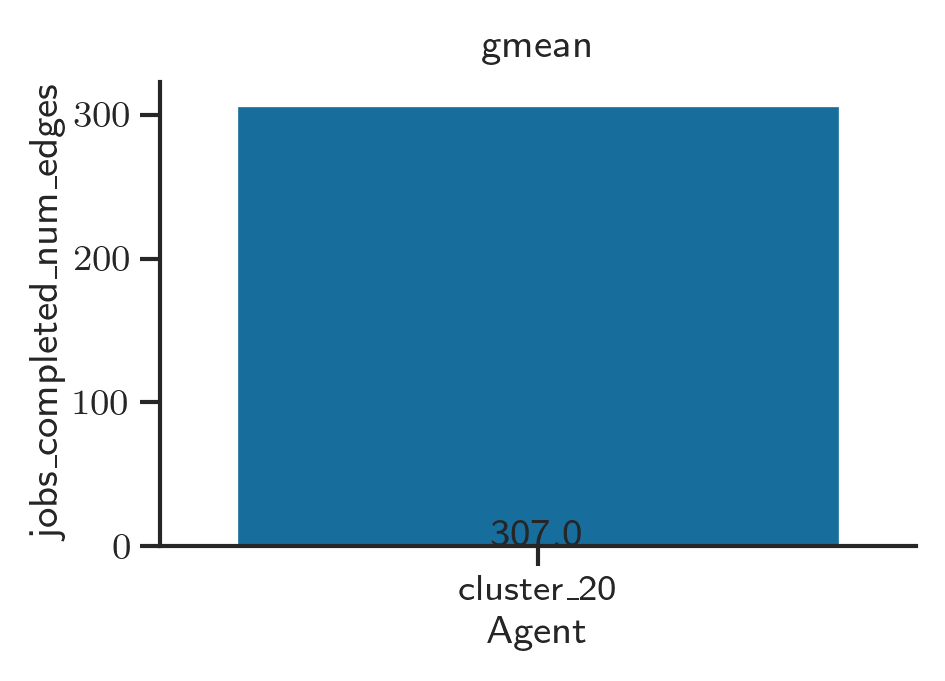

Plotting metric jobs_completed_total_operation_memory_cost


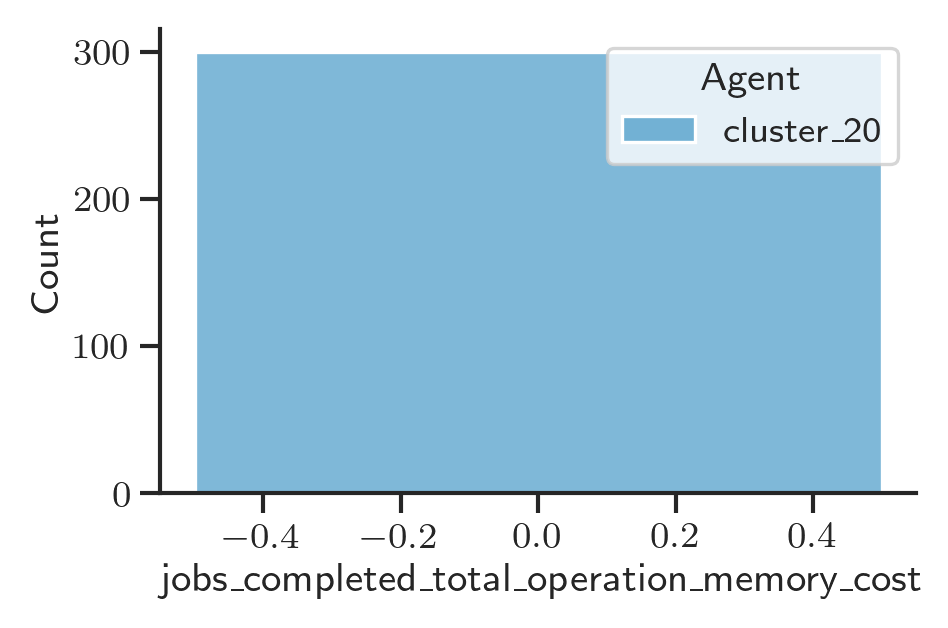

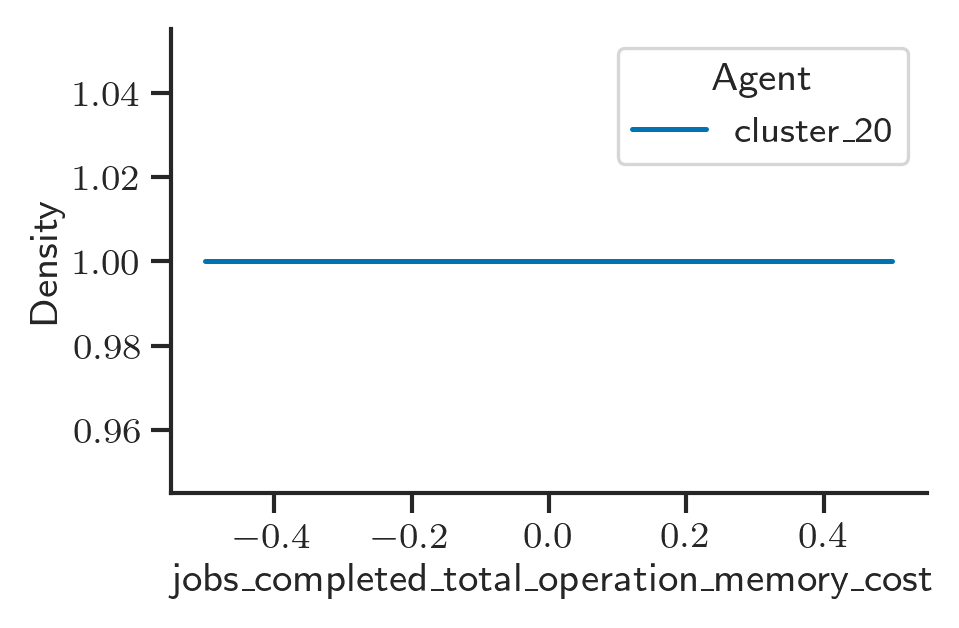

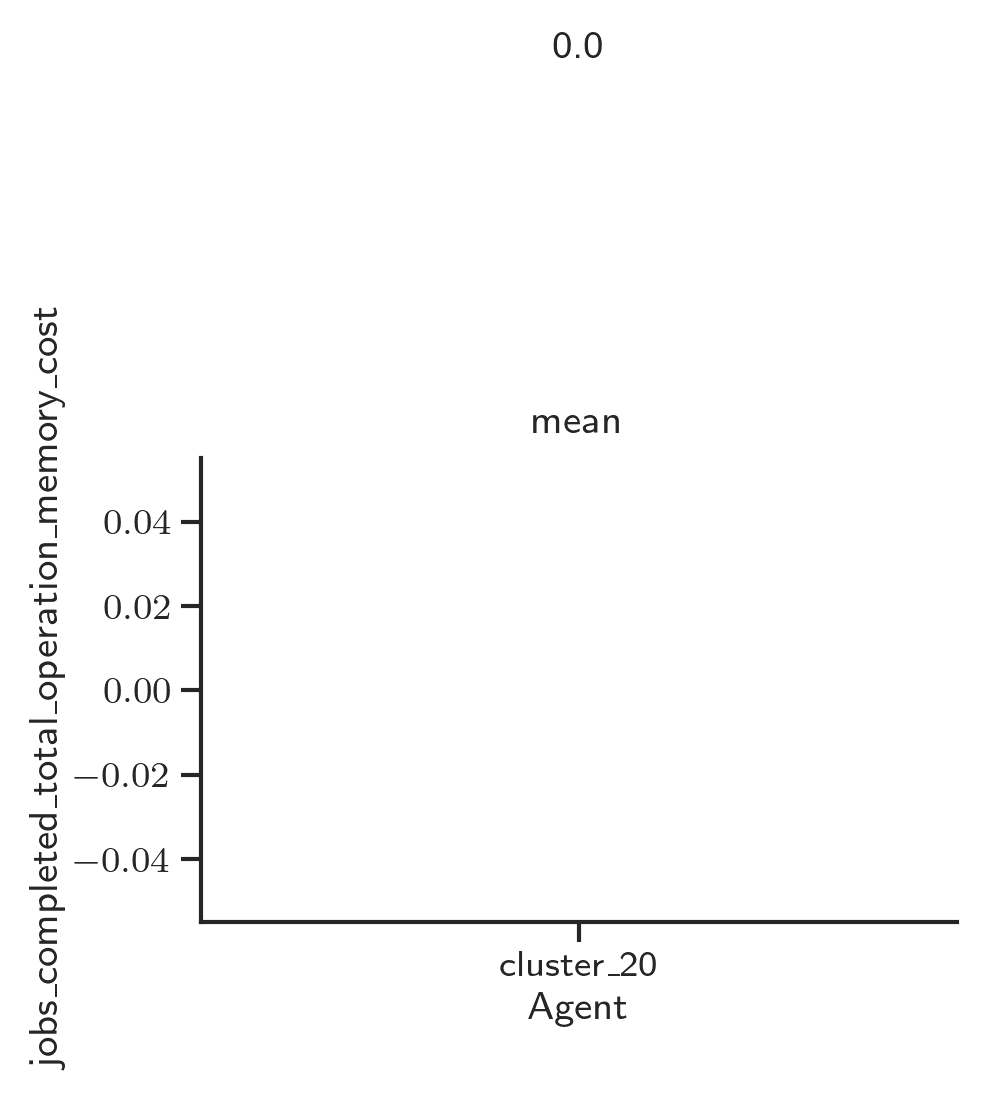

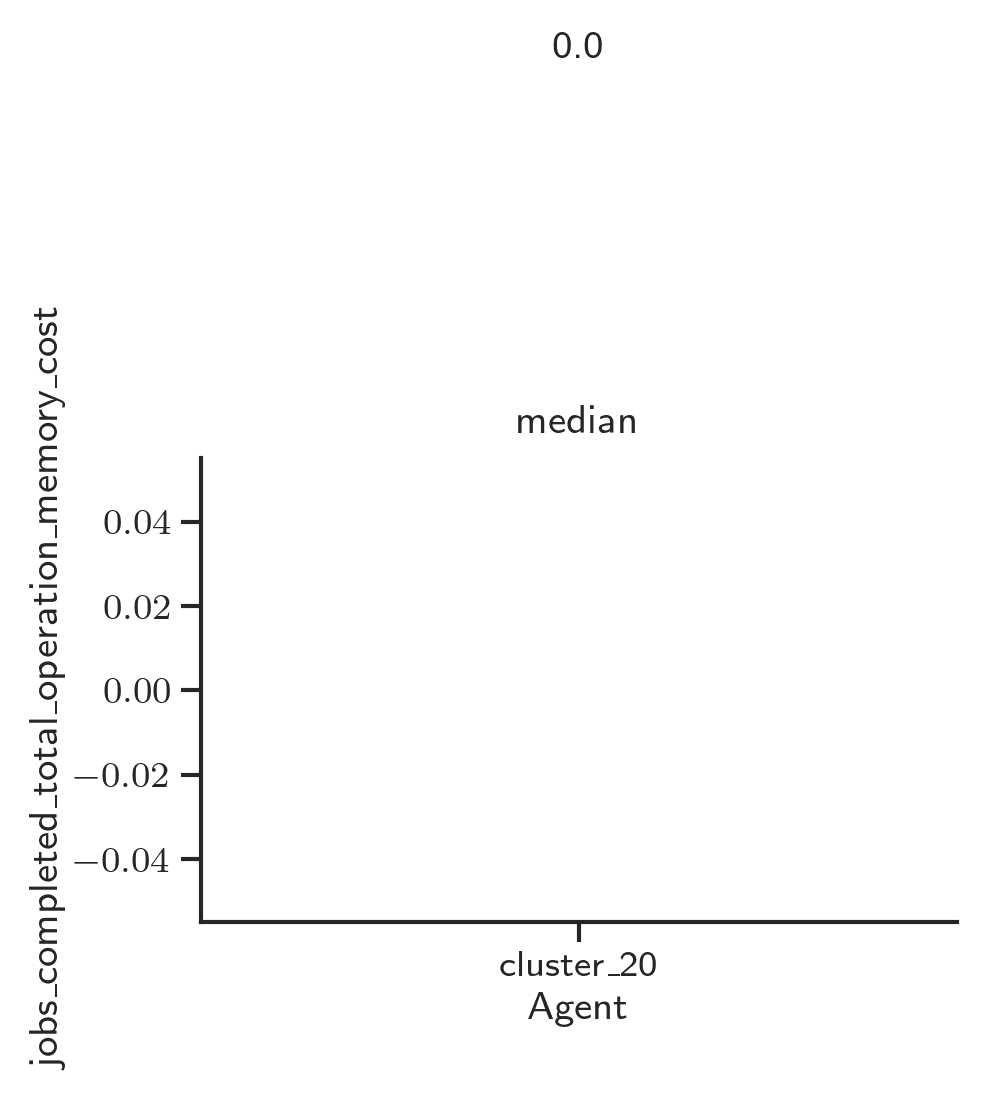

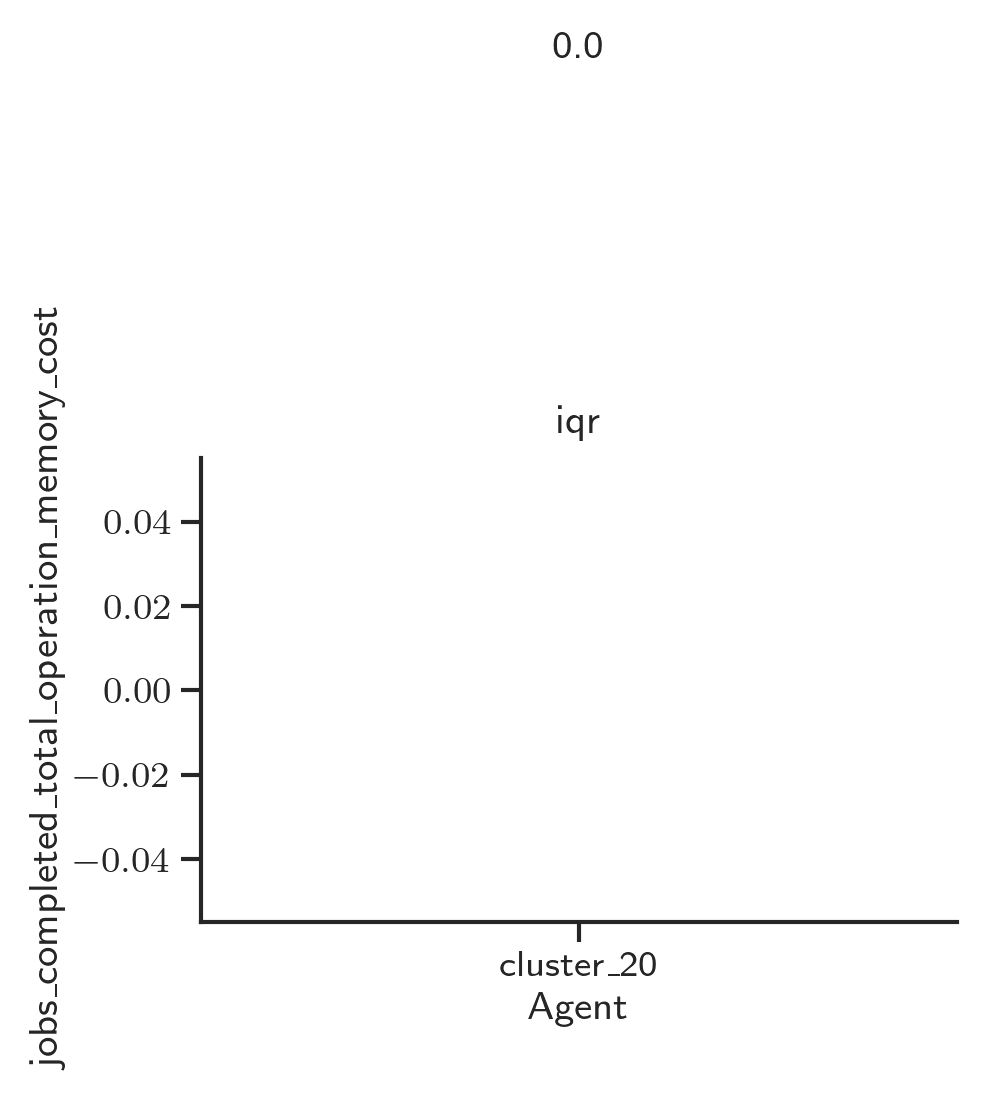

/scratch/zciccwf/py36/envs/ddls/lib/python3.9/site-packages/scipy/stats/stats.py:275: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(np.array(a, dtype=dtype))


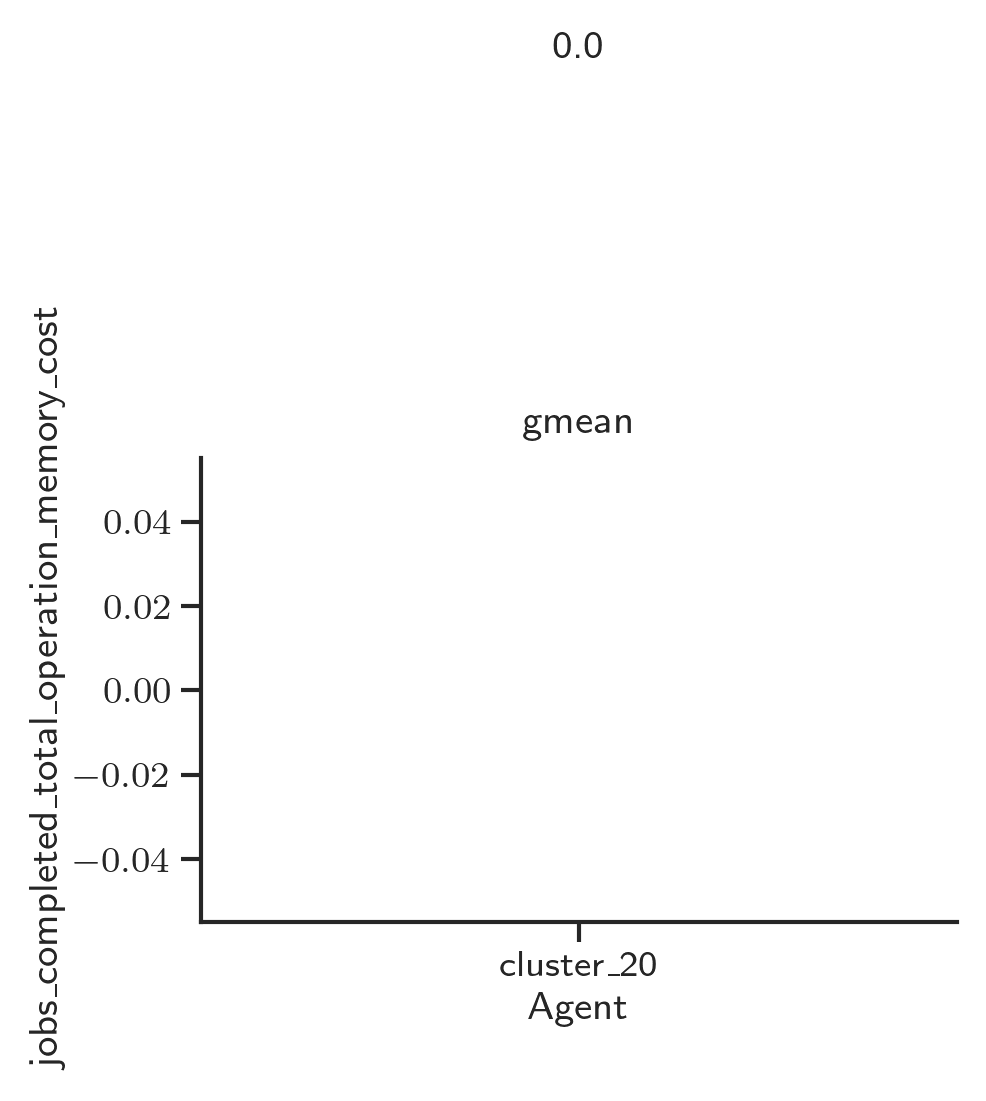

Plotting metric jobs_completed_total_dependency_size


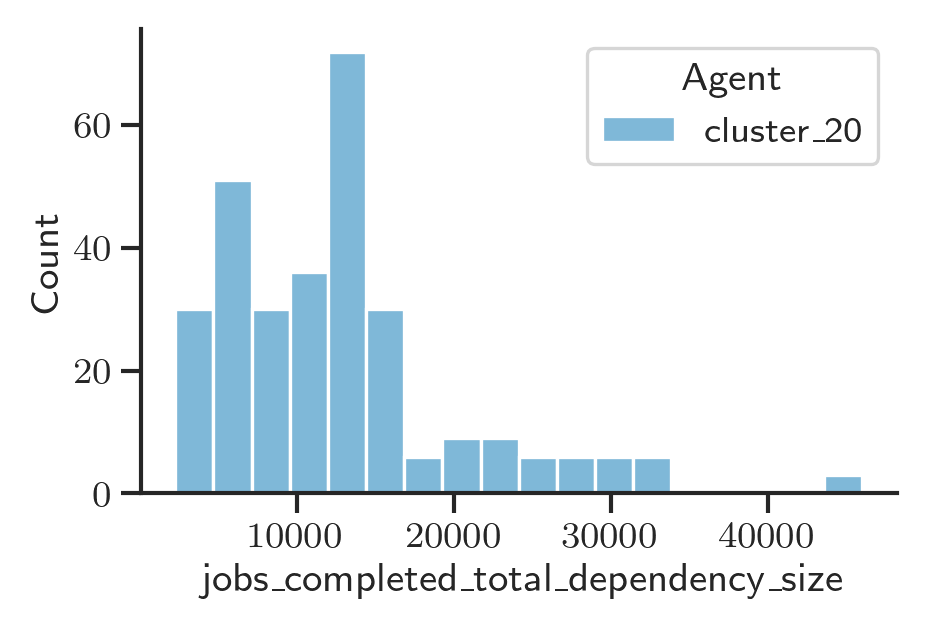

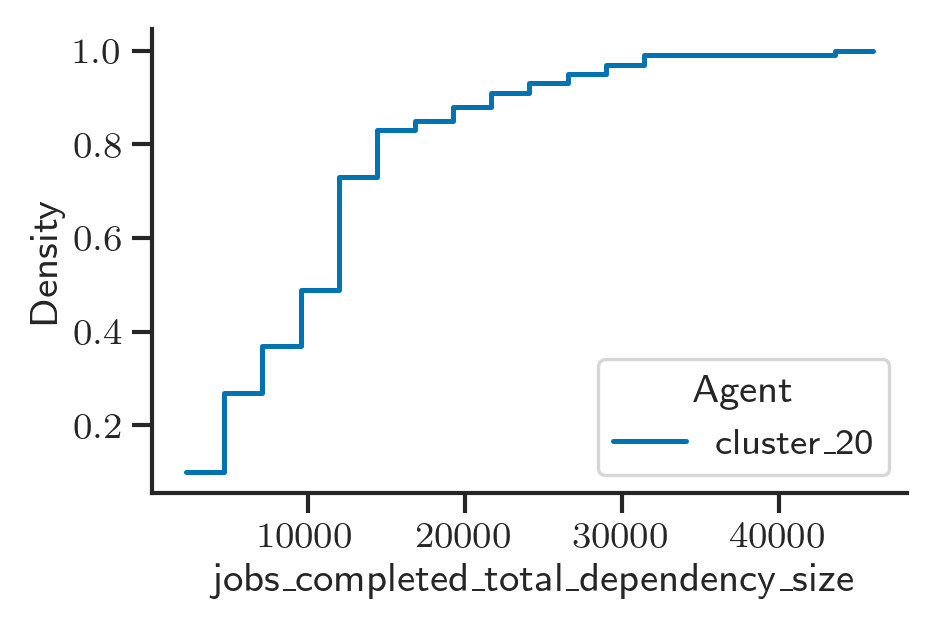

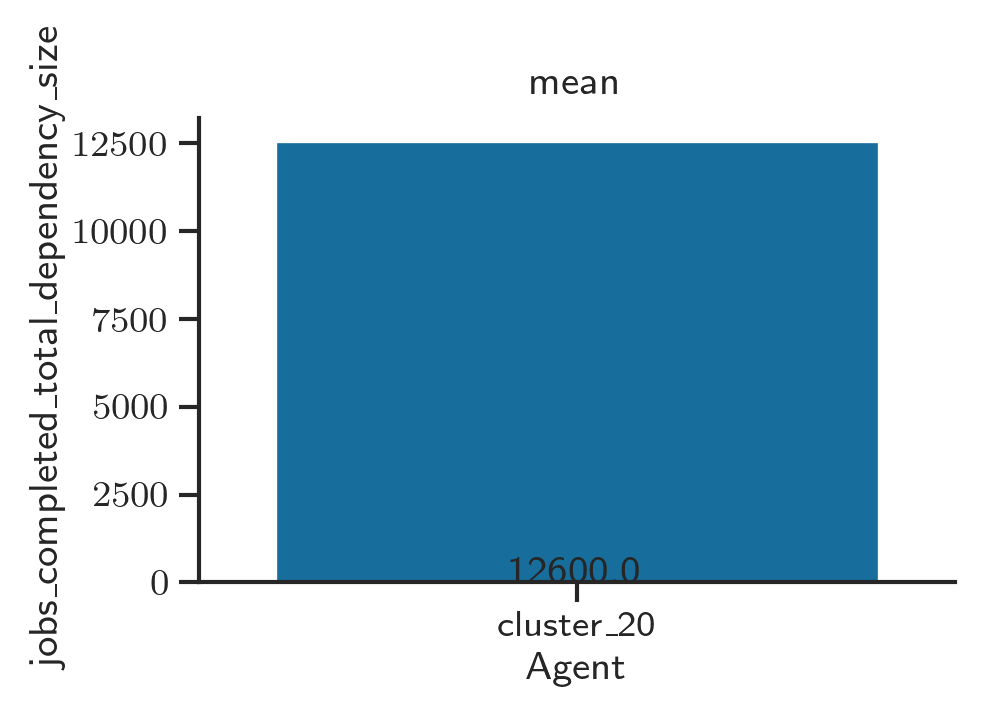

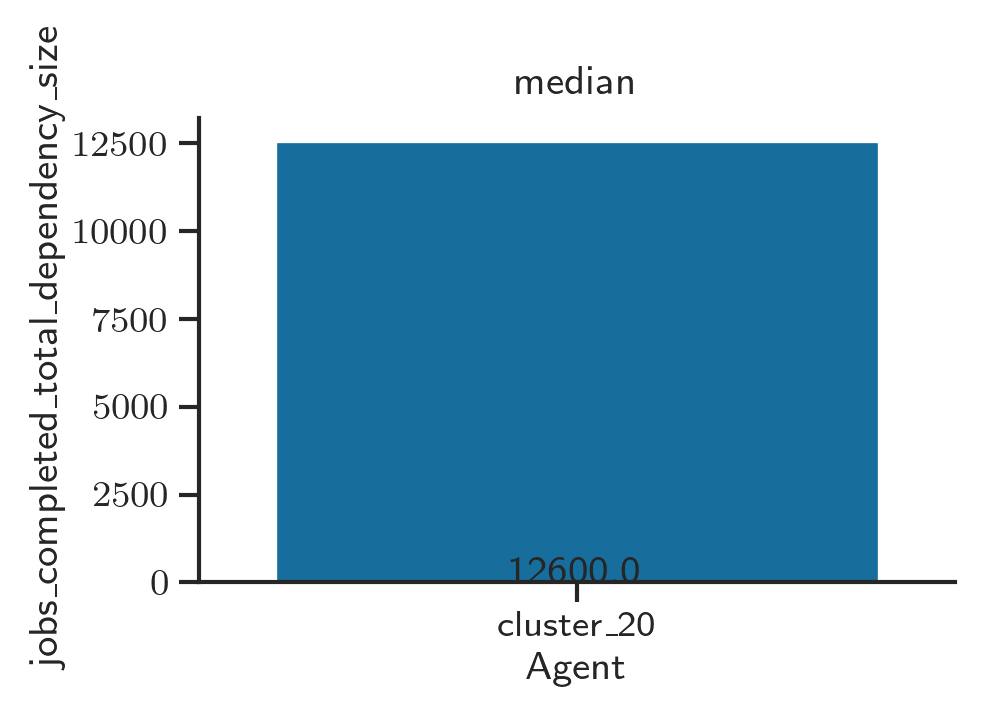

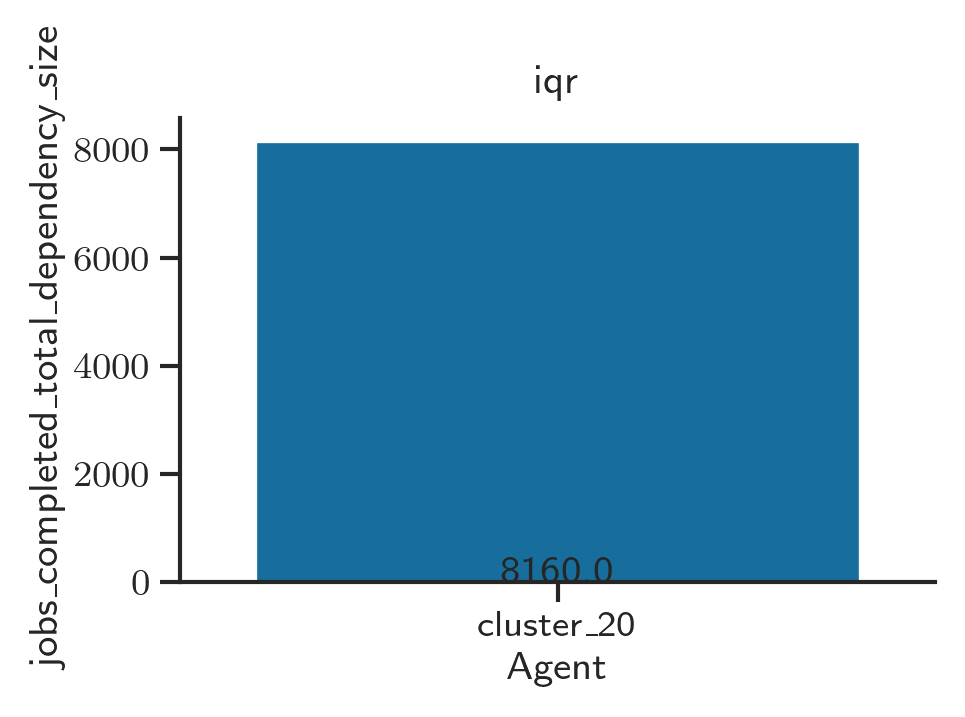

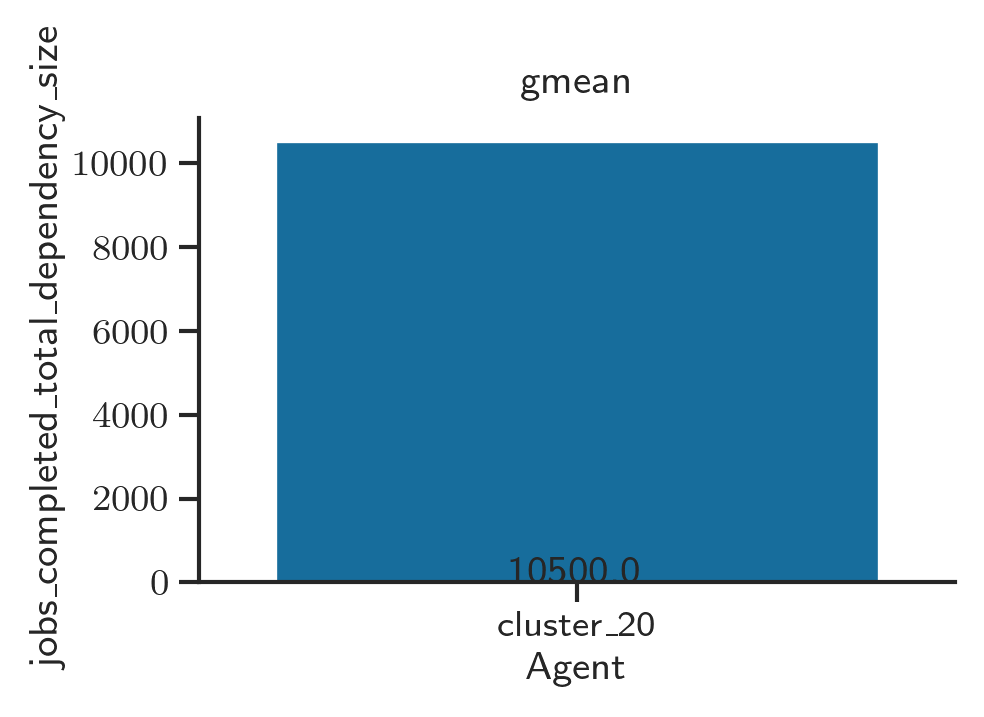

In [13]:
%autoreload
from ddls.plotting.plotting import plot_bar, plot_hist

import pandas as pd
from collections import defaultdict
import numpy as np
import scipy.stats as st


# plot config
scaling_factor = 1
metrics_to_skip = {}
estimators = {'mean': np.mean,
              'median': np.mean,
              'iqr': st.iqr,
              'gmean': st.gmean}


# make plots
metrics = sim_logs_dict[agent].keys()
metrics_to_plot = [metric for metric in metrics if metric not in metrics_to_skip]
print(f'Metrics to plot: {metrics_to_plot}\nMetrics to skip: {metrics_to_skip}\n')
for metric in metrics_to_plot:
    print(f'Plotting metric {metric}')
    plot_dict = {}
    for _agent in sim_logs_dict.keys():
        plot_dict['Agent'] = [_agent for _ in range(len(sim_logs_dict[_agent][metric]))]
        plot_dict[metric] = sim_logs_dict[agent][metric]
        
    df = pd.DataFrame(plot_dict)
        
    # hist
    fig = plot_hist(df,
                    x=metric,
                    hue='Agent',
                    xlabel=metric,
                    element='bars',
                    fill=True,
                    cumulative=False,
                    stat='count',
                    multiple='layer',
                    scaling_factor=scaling_factor,
                    show_fig=True)
    
    # cdf
    fig = plot_hist(df,
                    x=metric,
                    hue='Agent',
                    xlabel=metric,
                    element='step',
                    fill=False,
                    cumulative=True,
                    stat='density',
                    common_norm=False,
                    scaling_factor=scaling_factor,
                    show_fig=True)
        
    # bar chart
    for estimator_name, estimator in estimators.items():
        fig = plot_bar(df, 
                        x='Agent', 
                        y=metric, 
                        xlabel='Agent', 
                        ylabel=metric, 
                        estimator=estimator,
                        title=estimator_name,
                        scaling_factor=scaling_factor,
                        show_fig=True)